# Feature Engineering

## Objectives:

- In this notebook we will engineer the features for regression.

In order to do this we will follow the next tasks:
- Load and inspect the data prepared during data cleaning.
- Exploring the data.
- Feature engineering.
- Conclusion and next steps.

### Inputs:
- outputs/datasets/cleaned/train_set.csv
- outputs/datasets/cleaned/test_set.csv

### Outputs:

- List the variables that will be engineered.

### Additional comments:

+ This notebook was written based on the guidelines provided in the walk through project 2: 'Churnometer'.
+ This notebook relates to the Data Understanding step of Crisp-DM methodology. 
+ This notebook and the following will represent the learning outcome after following the Code Institute - Predictive Analytics and Machine Learning module.

___

## Change working directory.

- In the following steps we will modify the working directory from its current folder to its parent folder.

- Access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/5th-Project/jupyter_notebooks'

Make the parent of the current directory the new current directory:

- os.path.dirname() gets the parent directory.
- os.chir() defines the new current directory.

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory, congrats!")

You set a new current directory, congrats!


The following command will confirm the new current directory: 

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/5th-Project'

___

## Import the necessary packages and set environmental variables:

In [4]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

___

### Load the data from outputs/clean.

- Train set:

In [5]:
train_set_path = "outputs/datasets/cleaned/train_set.csv"
train_set = pd.read_csv(train_set_path)
train_set.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      1828         0             0           Av          48          Unk   
1       894         0             2           No           0          Unf   
2       964         0             2           No         713          ALQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  GrLivArea KitchenQual  \
0       1774         774          Unf         2007       1828          Gd   
1        894         308          Unf         1962        894          TA   
2        163         432          Unf         1921        964          TA   

   LotArea  LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0    11694           90         452          108            5            9   
1     6600           60           0            0            5            5   
2    13360           80           0            0            7            5   

   TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  
0         1822       2007          2007     314813  
1          894       1962          1962     109500  
2          876       1921          2006     163500

- Test set:

In [6]:
test_set_path = "outputs/datasets/cleaned/test_set.csv"
test_set = pd.read_csv(test_set_path)
test_set.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      2515         0             4           No        1219          Rec   
1       958       620             3           No         403          BLQ   
2       979       224             3           No         185          LwQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  GrLivArea KitchenQual  \
0        816         484          Unf         1975       2515          TA   
1        238         240          Unf         1941       1578          Fa   
2        524         352          Unf         1950       1203          Gd   

   LotArea  LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0    32668           69           0            0            3            6   
1     9490           79           0            0            7            6   
2     7015           69         161            0            4            5   

   TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  
0         2035       1957          1975     200624  
1          806       1941          1950     133000  
2          709       1950          1950     110000

___

## Feature Engineering

- In this part of the notebook we will analyze and transform the functions.
- We will be using the function from feature-engine lesson, and costume to our needs in order to implement the feature engineering process. 

In [8]:
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

def FeatureEngineeringAnalysis(df,analysis_type=None):
  """
  - used for quick feature engineering on numerical and categorical variables
  to decide which transformation can better transform the distribution shape 
  - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions

  """
  check_missing_values(df)
  allowed_types= ['numerical', 'ordinal_encoder',  'outlier_winsorizer']
  check_user_entry_on_analysis_type(analysis_type, allowed_types)
  list_column_transformers = define_list_column_transformers(analysis_type)
  
  
  # Loop in each variable and engineer the data according to the analysis type
  df_feat_eng = pd.DataFrame([])
  for column in df.columns:
    # create additional columns (column_method) to apply the methods
    df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
    for method in list_column_transformers:
      df_feat_eng[f"{column}_{method}"] = df[column]
      
    # Apply transformers in respectives column_transformers
    df_feat_eng,list_applied_transformers = apply_transformers(analysis_type, df_feat_eng, column)

    # For each variable, assess how the transformations perform
    transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng)

  return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
  ### Check analyis type
  if analysis_type == None:
    raise SystemExit(f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
  if analysis_type not in allowed_types:
      raise SystemExit(f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
  if df.isna().sum().sum() != 0:
    raise SystemExit(
        f"There is missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
  ### Set suffix colummns acording to analysis_type
  if analysis_type=='numerical':
    list_column_transformers = ["log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]
  
  elif analysis_type=='ordinal_encoder':
    list_column_transformers = ["ordinal_encoder"]

  elif analysis_type=='outlier_winsorizer':
    list_column_transformers = ['iqr']

  return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):


  for col in df_feat_eng.select_dtypes(include='category').columns: df_feat_eng[col] = df_feat_eng[col].astype('object')


  if analysis_type=='numerical':
    df_feat_eng,list_applied_transformers = FeatEngineering_Numerical(df_feat_eng,column)
  
  elif analysis_type=='outlier_winsorizer':
    df_feat_eng,list_applied_transformers = FeatEngineering_OutlierWinsorizer(df_feat_eng,column)

  elif analysis_type=='ordinal_encoder':
    df_feat_eng,list_applied_transformers = FeatEngineering_CategoricalEncoder(df_feat_eng,column)

  return df_feat_eng,list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
  # For each variable, assess how the transformations perform
  print(f"* Variable Analyzed: {column}")
  print(f"* Applied transformation: {list_applied_transformers} \n")
  transformer_column = column + '_' + analysis_type
  
  for col in [column] + list_applied_transformers:
    
    if analysis_type!='ordinal_encoder':
      DiagnosticPlots_Numerical(df_feat_eng, col)
    
    else:
      print(f"{df_feat_eng.set_index(transformer_column).groupby([transformer_column, column]).size()} \n")
      if col == column: 
        DiagnosticPlots_Categories(df_feat_eng, col)
      else:
        DiagnosticPlots_Numerical(df_feat_eng, col)

    print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
  plt.figure(figsize=(4, 3))
  sns.countplot(data=df_feat_eng, x=col,palette=['#432371'],order = df_feat_eng[col].value_counts().index)
  plt.xticks(rotation=90) 
  plt.suptitle(f"{col}", fontsize=30,y=1.05)        
  plt.show()
  print("\n")


def DiagnosticPlots_Numerical(df, variable):
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  sns.histplot(data=df, x=variable, kde=True,element="step",ax=axes[0]) 
  stats.probplot(df[variable], dist="norm", plot=axes[1])
  sns.boxplot(x=df[variable],ax=axes[2])
  
  axes[0].set_title('Histogram')
  axes[1].set_title('QQ Plot')
  axes[2].set_title('Boxplot')
  fig.suptitle(f"{variable}", fontsize=30,y=1.05)
  plt.tight_layout()
  plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng,column):
  list_methods_worked = []
  try:  
    encoder= OrdinalEncoder(encoding_method='arbitrary', variables = [f"{column}_ordinal_encoder"])
    df_feat_eng = encoder.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_ordinal_encoder")
  
  except: 
    df_feat_eng.drop([f"{column}_ordinal_encoder"],axis=1,inplace=True)
    
  return df_feat_eng,list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng,column):
  list_methods_worked = []

  ### Winsorizer iqr
  try: 
    disc=Winsorizer(
        capping_method='iqr', tail='both', fold=1.5, variables = [f"{column}_iqr"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_iqr")
  except: 
    df_feat_eng.drop([f"{column}_iqr"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked


def FeatEngineering_Numerical(df_feat_eng,column):

  list_methods_worked = []

  ### LogTransformer base e
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_e"])
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_e")
  except: 
    df_feat_eng.drop([f"{column}_log_e"],axis=1,inplace=True)

  ### LogTransformer base 10
  try:  
    lt = vt.LogTransformer(variables = [f"{column}_log_10"],base='10')
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_10")
  except: 
    df_feat_eng.drop([f"{column}_log_10"],axis=1,inplace=True)

  ### ReciprocalTransformer
  try:
    rt = vt.ReciprocalTransformer(variables = [f"{column}_reciprocal"])
    df_feat_eng =  rt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_reciprocal")
  except:
    df_feat_eng.drop([f"{column}_reciprocal"],axis=1,inplace=True)

  ### PowerTransformer
  try:
    pt = vt.PowerTransformer(variables = [f"{column}_power"])
    df_feat_eng = pt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_power")
  except:
    df_feat_eng.drop([f"{column}_power"],axis=1,inplace=True)

  ### BoxCoxTransformer
  try:
    bct = vt.BoxCoxTransformer(variables = [f"{column}_box_cox"])
    df_feat_eng = bct.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_box_cox")
  except:
    df_feat_eng.drop([f"{column}_box_cox"],axis=1,inplace=True)

  ### YeoJohnsonTransformer
  try:
    yjt = vt.YeoJohnsonTransformer(variables = [f"{column}_yeo_johnson"])
    df_feat_eng = yjt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_yeo_johnson")
  except:
        df_feat_eng.drop([f"{column}_yeo_johnson"],axis=1,inplace=True)

  return df_feat_eng,list_methods_worked

___

### Transformers data to be used:

- These are the transformer that will be used and will be applied in this order:
    - Categorical Encoding.
    - Numerical Transformation.
    - Smart Correlation Selection.



### Categorical Encoding:

- The following steps will replace categorical data with ordinal numbers:

1. Declare a variable with categorical variable names:

In [9]:
categorical_variables = list(train_set.select_dtypes(['object','category']).columns)
categorical_variables

['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

2. Create a data frame for a subset of the Train dataset using the above variables:


In [10]:
df_categorical = train_set[categorical_variables].copy()
df_categorical.head()

BsmtExposure BsmtFinType1 GarageFinish KitchenQual
0           Av          Unk          Unf          Gd
1           No          Unf          Unf          TA
2           No          ALQ          Unf          TA
3           No          GLQ          RFn          Gd
4           No          Unf          RFn          Gd

3. Apply the transformation to the variables.
    - Assess the distribution. (We need to do this process so that we can find the most suitable method for each variable)

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 

BsmtExposure_ordinal_encoder  BsmtExposure
0                             Av              174
1                             No              768
2                             Gd              106
3                             None             28
4                             Mn               92
dtype: int64 



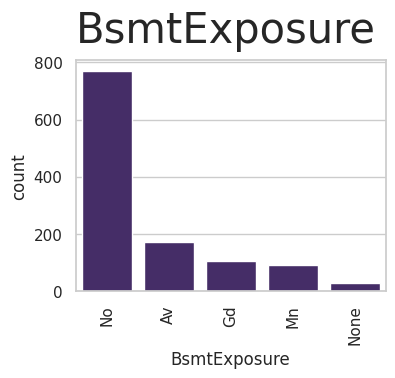





BsmtExposure_ordinal_encoder  BsmtExposure
0                             Av              174
1                             No              768
2                             Gd              106
3                             None             28
4                             Mn               92
dtype: int64 



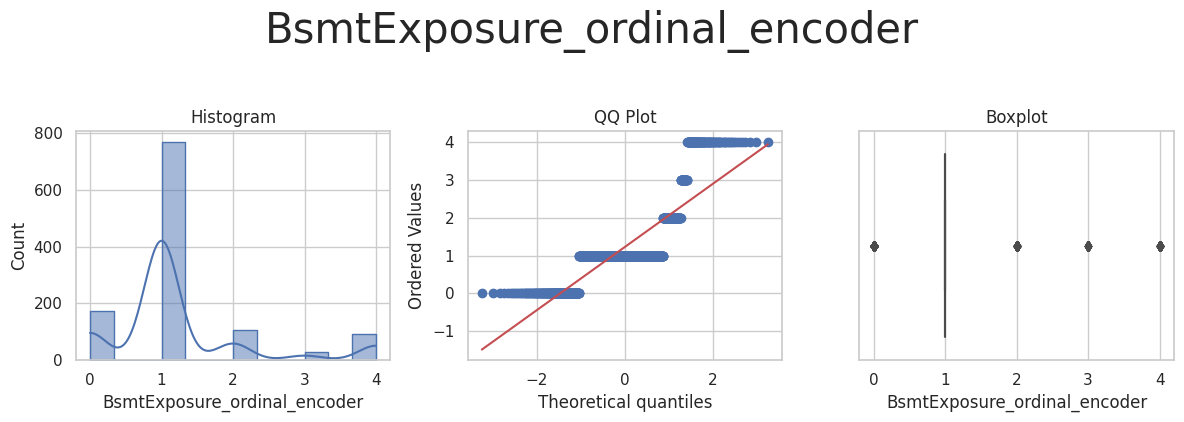



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 

BsmtFinType1_ordinal_encoder  BsmtFinType1
0                             Unk              59
1                             Unf             353
2                             ALQ             159
3                             GLQ             303
4                             Rec             100
5                             None             28
6                             LwQ              52
7                             BLQ             114
dtype: int64 



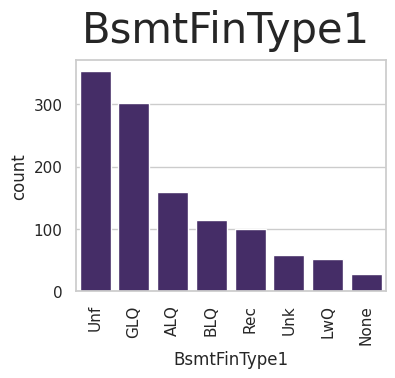





BsmtFinType1_ordinal_encoder  BsmtFinType1
0                             Unk              59
1                             Unf             353
2                             ALQ             159
3                             GLQ             303
4                             Rec             100
5                             None             28
6                             LwQ              52
7                             BLQ             114
dtype: int64 



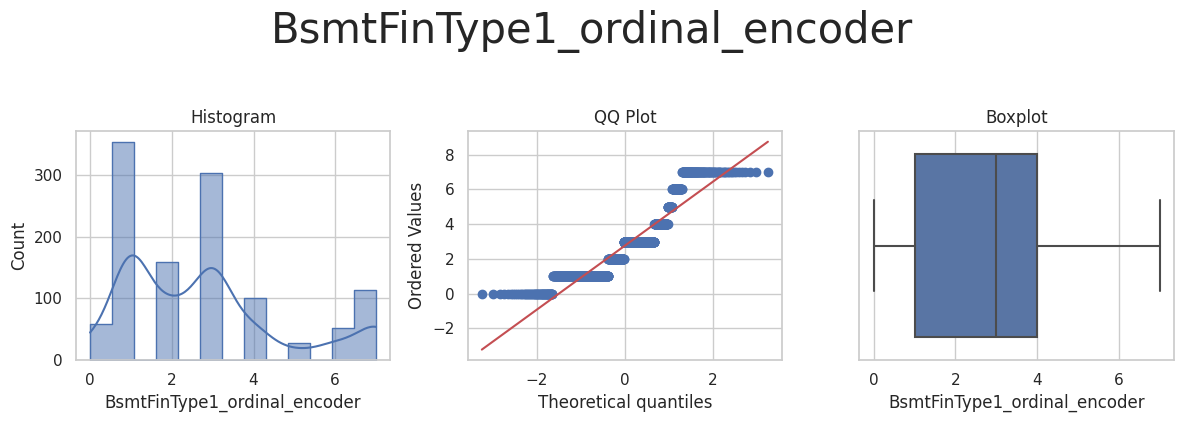



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 

GarageFinish_ordinal_encoder  GarageFinish
0                             Unf             563
1                             RFn             293
2                             Fin             254
3                             None             58
dtype: int64 



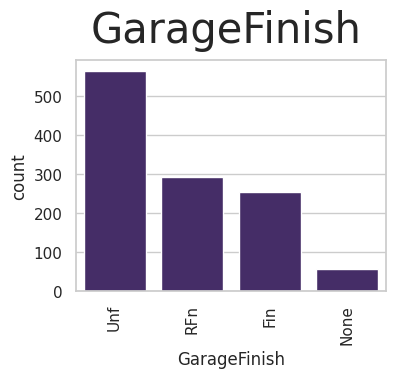





GarageFinish_ordinal_encoder  GarageFinish
0                             Unf             563
1                             RFn             293
2                             Fin             254
3                             None             58
dtype: int64 



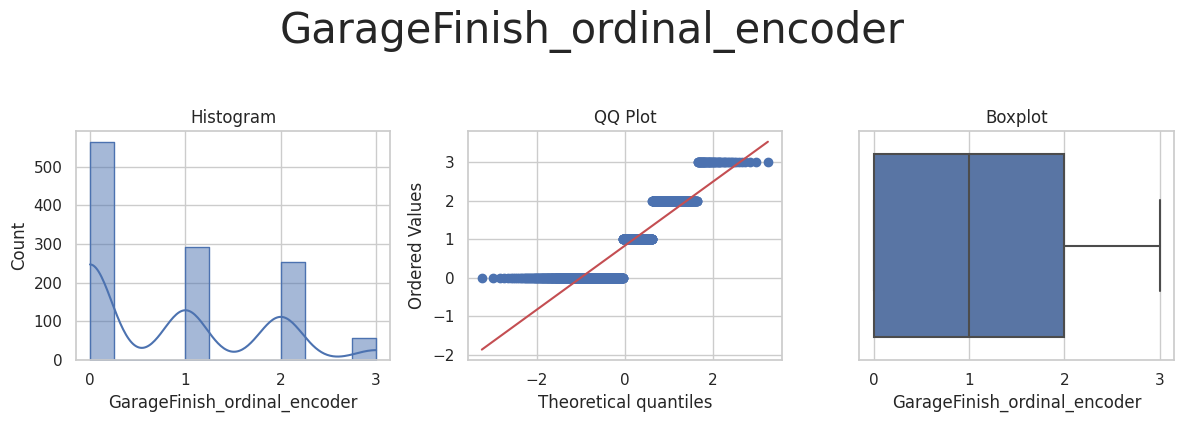



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 

KitchenQual_ordinal_encoder  KitchenQual
0                            Gd             462
1                            TA             596
2                            Ex              78
3                            Fa              32
dtype: int64 



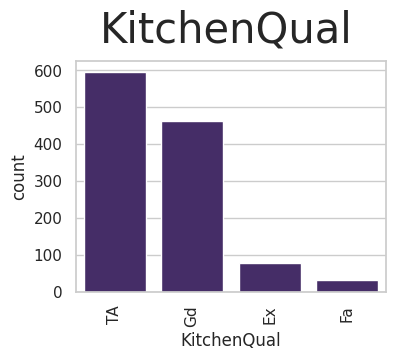





KitchenQual_ordinal_encoder  KitchenQual
0                            Gd             462
1                            TA             596
2                            Ex              78
3                            Fa              32
dtype: int64 



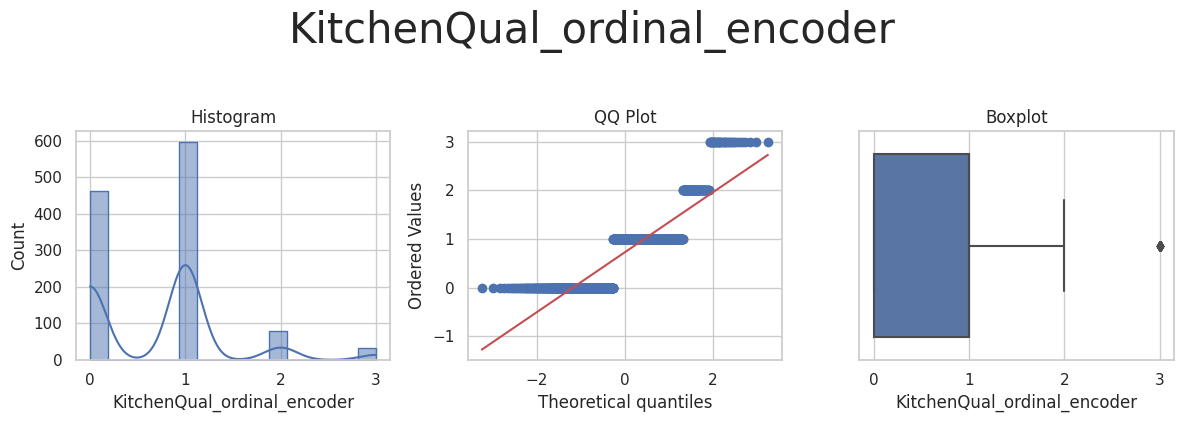

In [11]:
df_categorical_engineered = FeatureEngineeringAnalysis(df=df_categorical, analysis_type='ordinal_encoder')

*Conclusion:*
- *After transformation, we cold observe how effective was the transformation from categorical to numerical.*

4. The transformation has to be applied to the Train and Test set:

In [12]:
encoder = OrdinalEncoder(encoding_method='arbitrary', variables=categorical_variables)
train_set = encoder.fit_transform(train_set)
test_set = encoder.transform(test_set)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


___

## Numerical Transformation:

1. Declare a variable with the numerical variable names:

In [13]:
numerical_variables = list(train_set.select_dtypes(['int64','float64']).columns)
numerical_variables

['1stFlrSF',
 '2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinType1',
 'BsmtUnfSF',
 'GarageArea',
 'GarageFinish',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenQual',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd',
 'SalePrice']

2. Create a data frame from a subset of the Train set using the above variable:

In [14]:
df_numerical = train_set[numerical_variables].copy()
df_numerical.head()

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0      1828         0             0             0          48             0   
1       894         0             2             1           0             1   
2       964         0             2             1         713             2   
3      1689         0             3             1        1218             3   
4      1541         0             3             1           0             1   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  GrLivArea  KitchenQual  \
0       1774         774             0         2007       1828            0   
1        894         308             0         1962        894            1   
2        163         432             0         1921        964            1   
3        350         857             1         2002       1689            0   
4       1541         843             1         2001       1541            0   

   LotArea  LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0    11694           90         452          108            5            9   
1     6600           60           0            0            5            5   
2    13360           80           0            0            7            5   
3    13265           69         148           59            5            8   
4    13704          118         150           81            5            7   

   TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  
0         1822       2007          2007     314813  
1          894       1962          1962     109500  
2          876       1921          2006     163500  
3         1568       2002          2002     271000  
4         1541       2001          2002     205000

3. Apply the transformation to these variables and assess the distribution. 
    - Find the most efficient method for each: 

* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



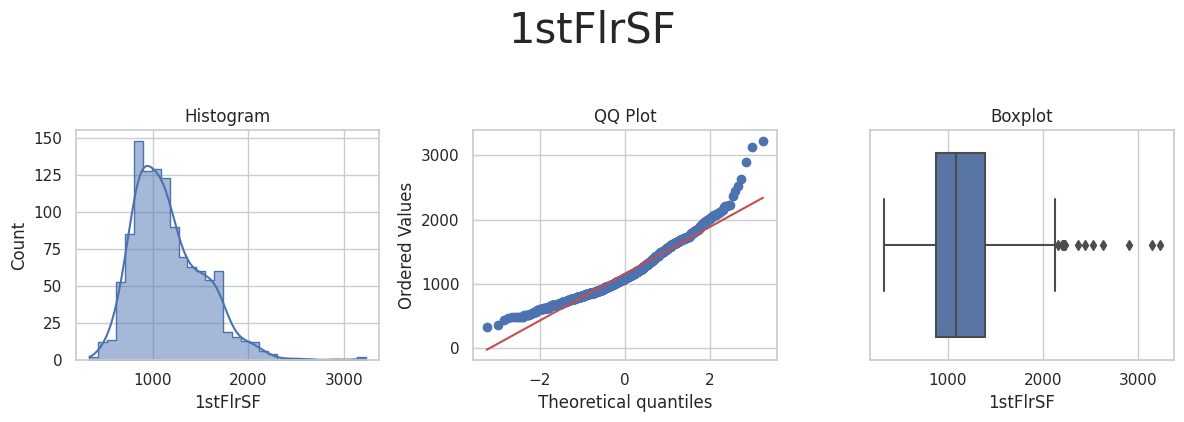

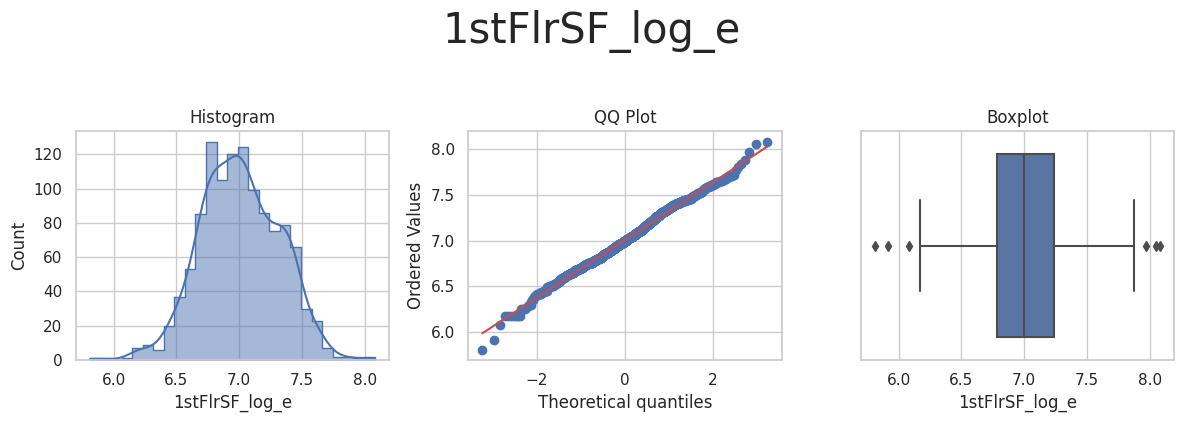

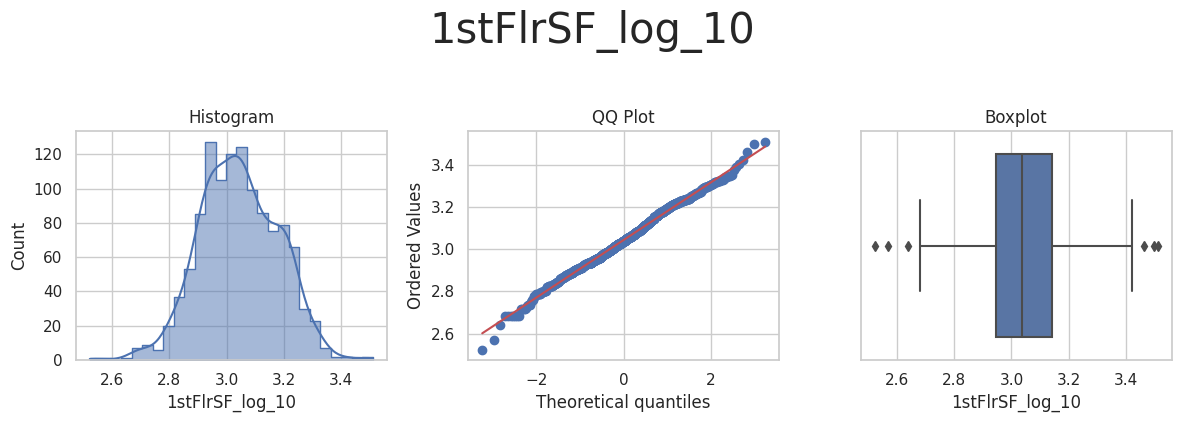

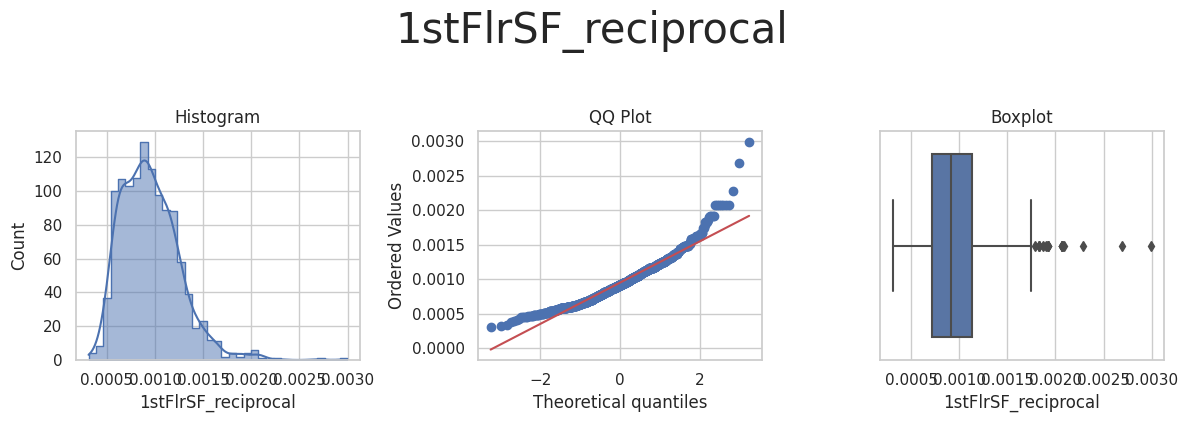

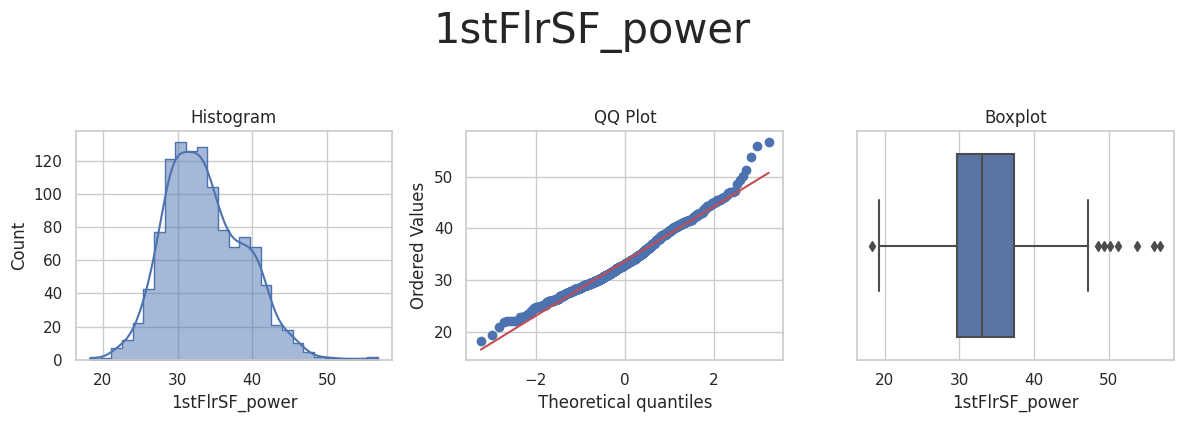

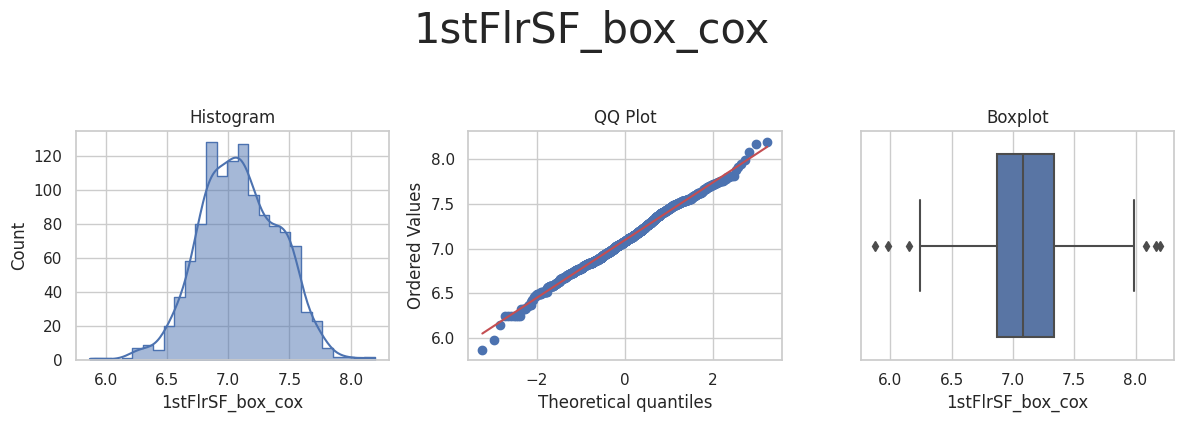

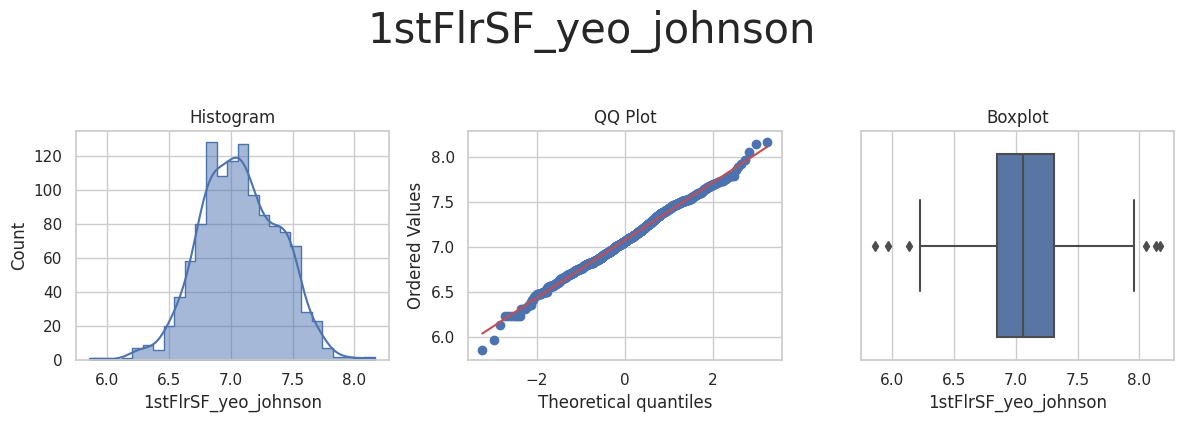



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 



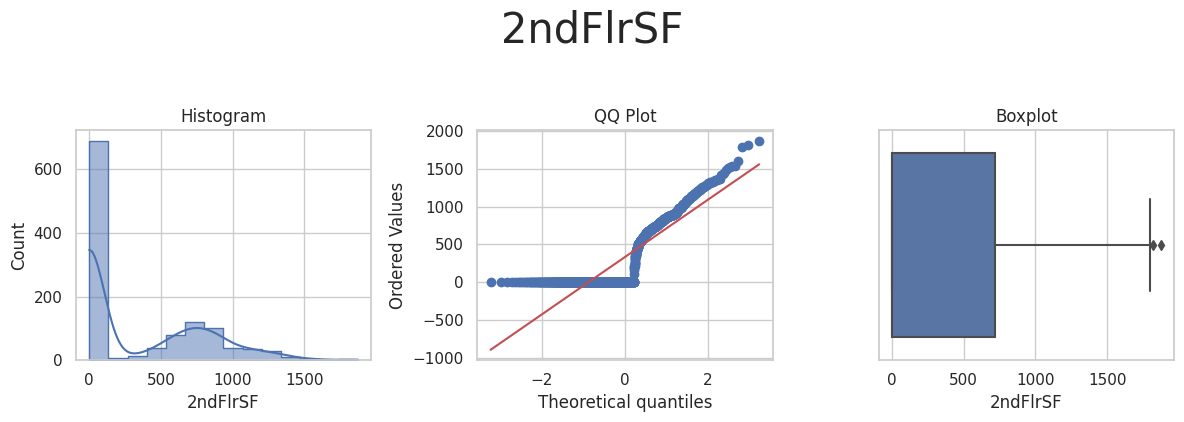

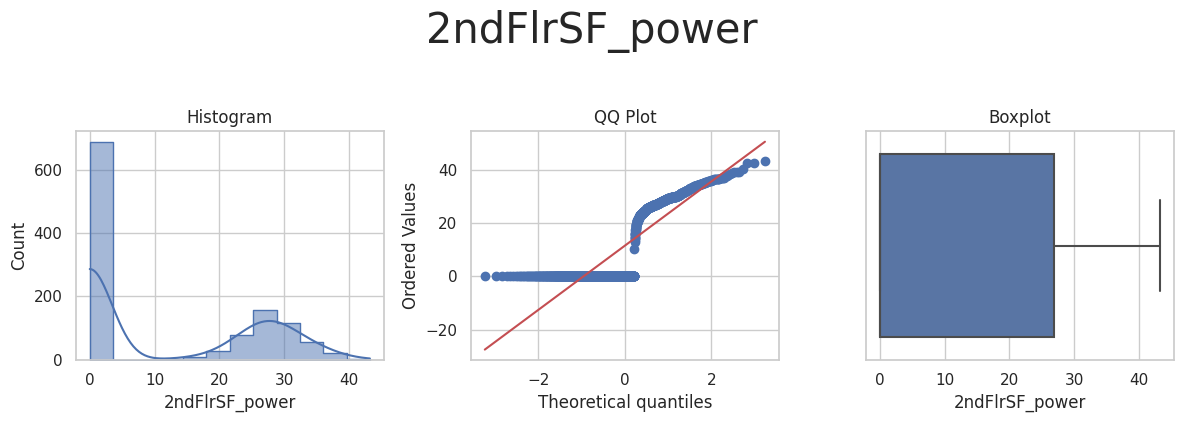

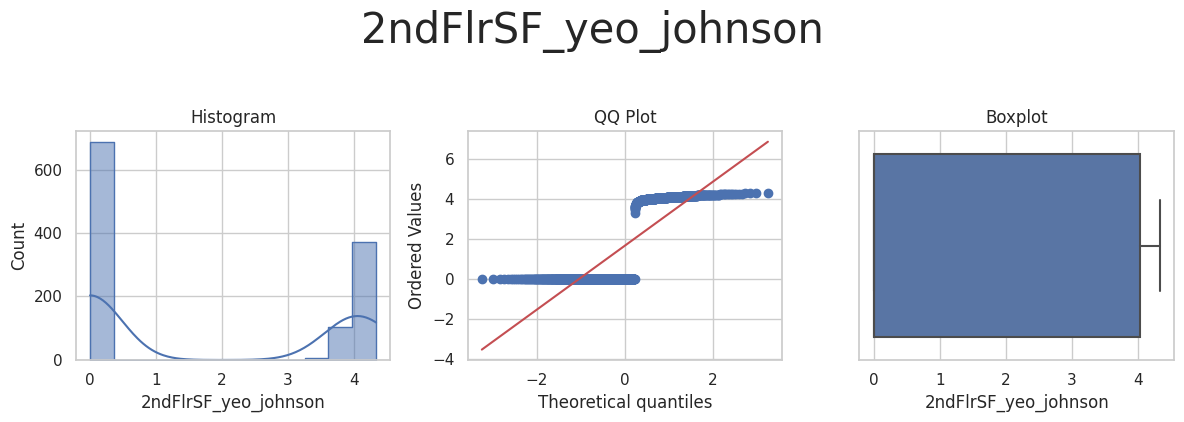



* Variable Analyzed: BedroomAbvGr
* Applied transformation: ['BedroomAbvGr_power', 'BedroomAbvGr_yeo_johnson'] 



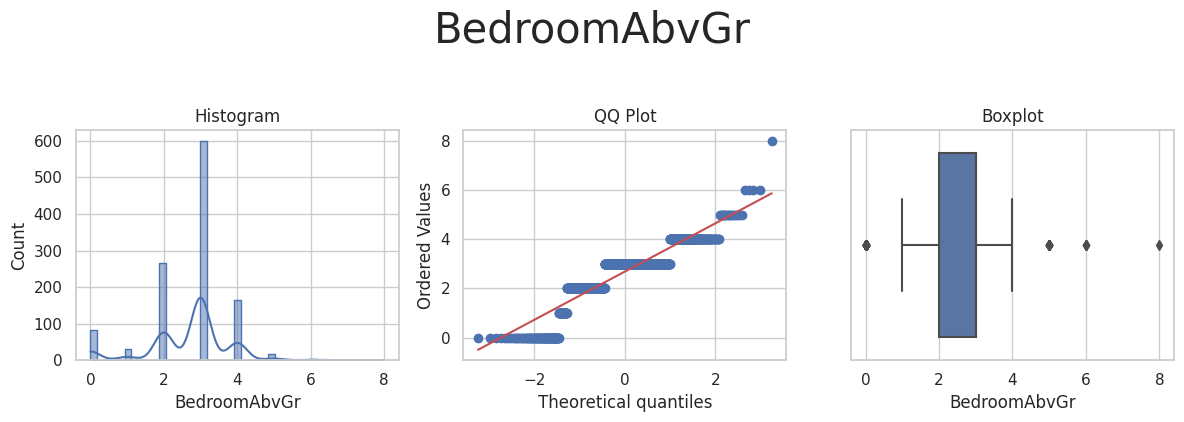

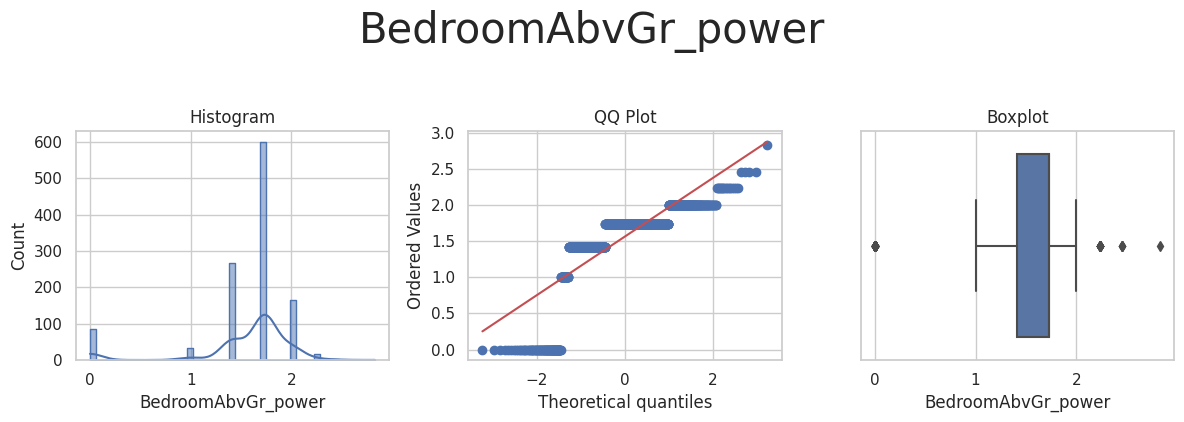

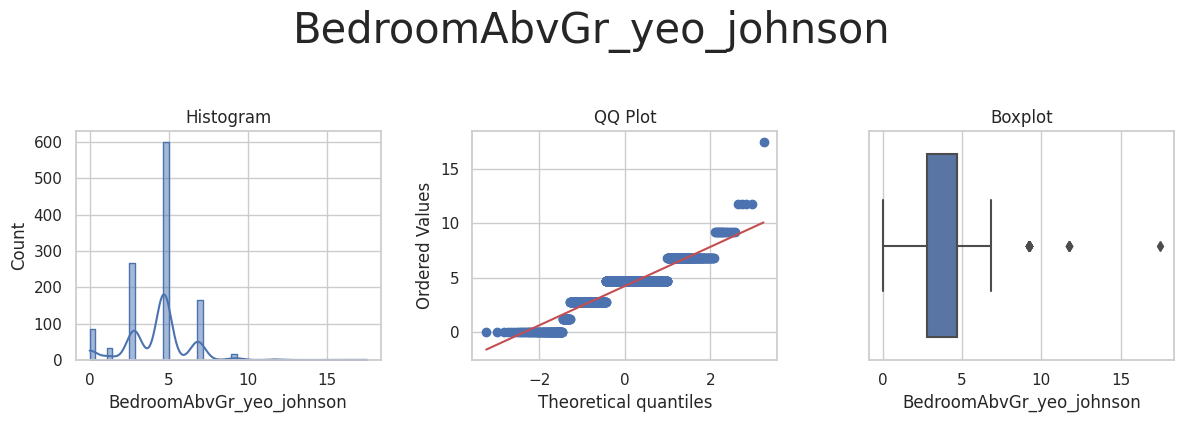



* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_power', 'BsmtExposure_yeo_johnson'] 



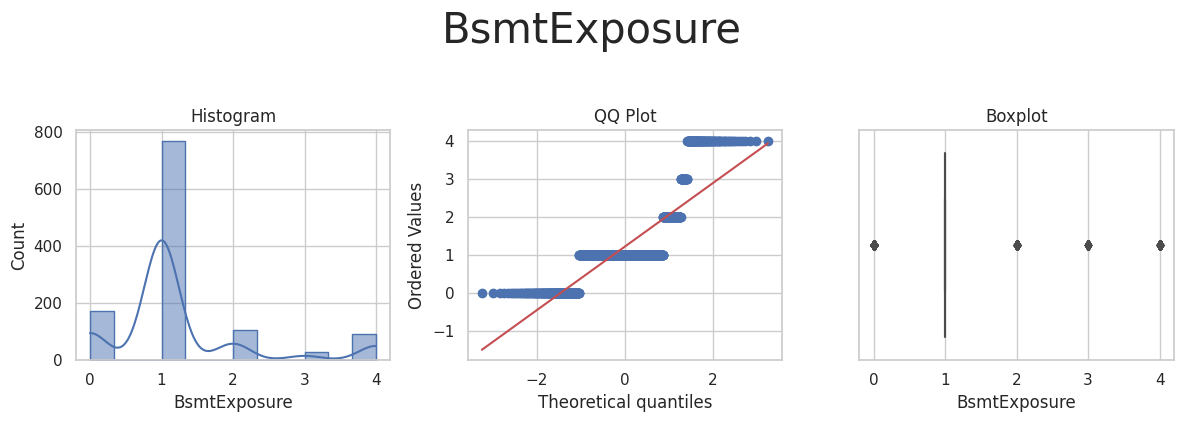

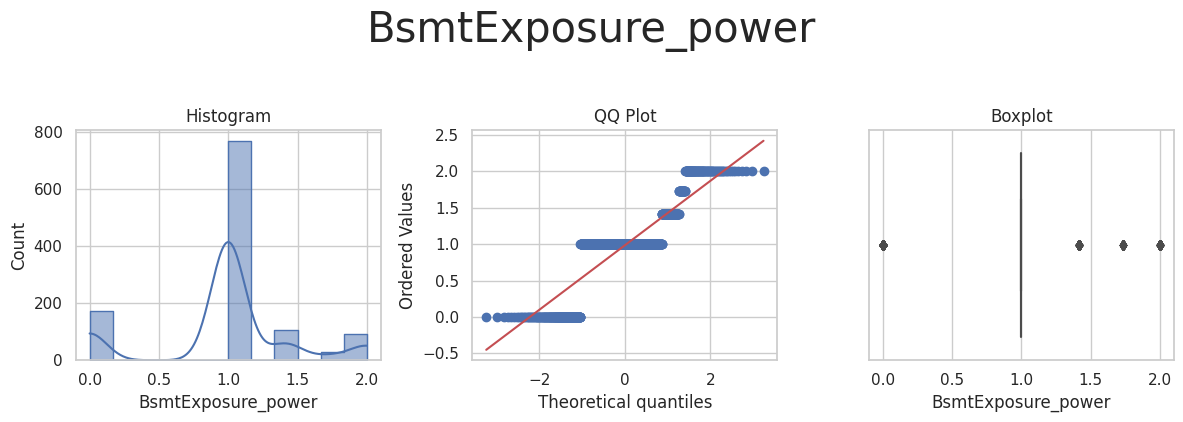

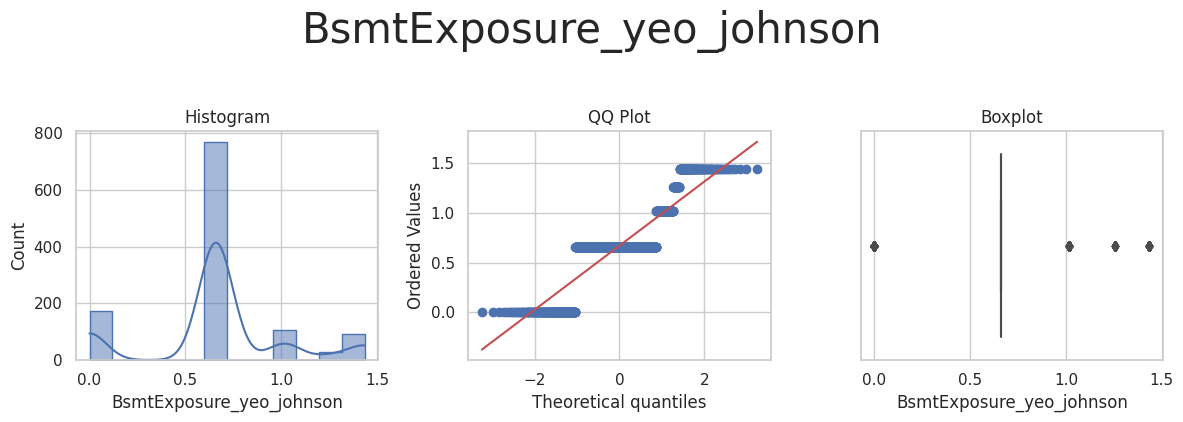



* Variable Analyzed: BsmtFinSF1
* Applied transformation: ['BsmtFinSF1_power', 'BsmtFinSF1_yeo_johnson'] 



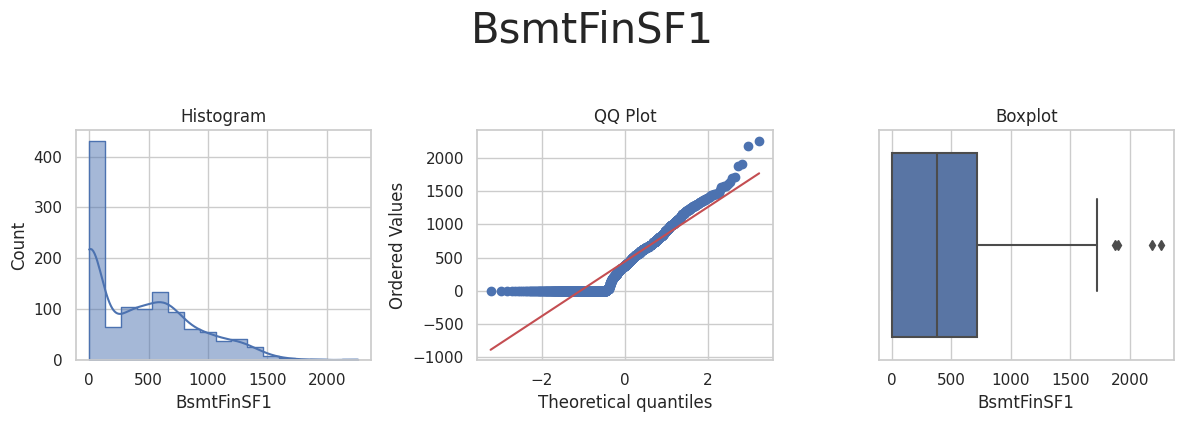

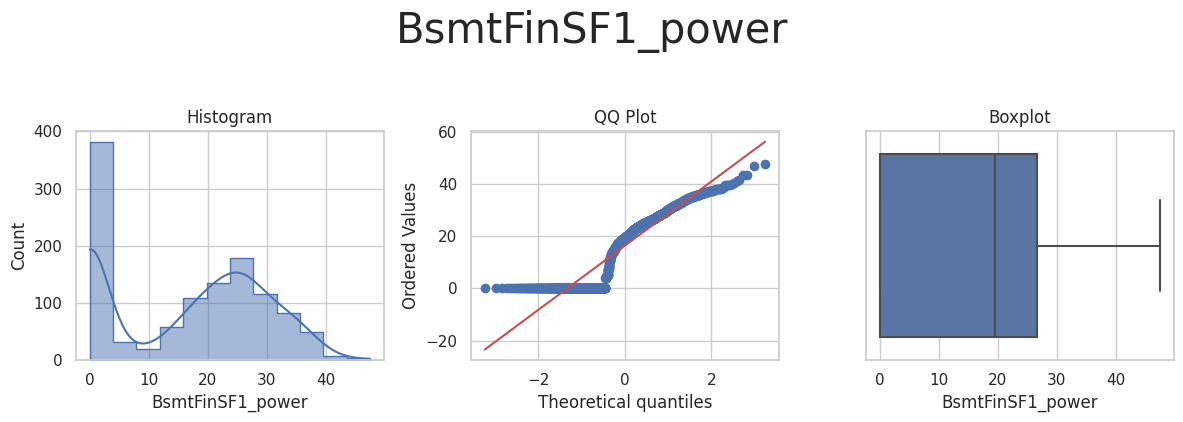

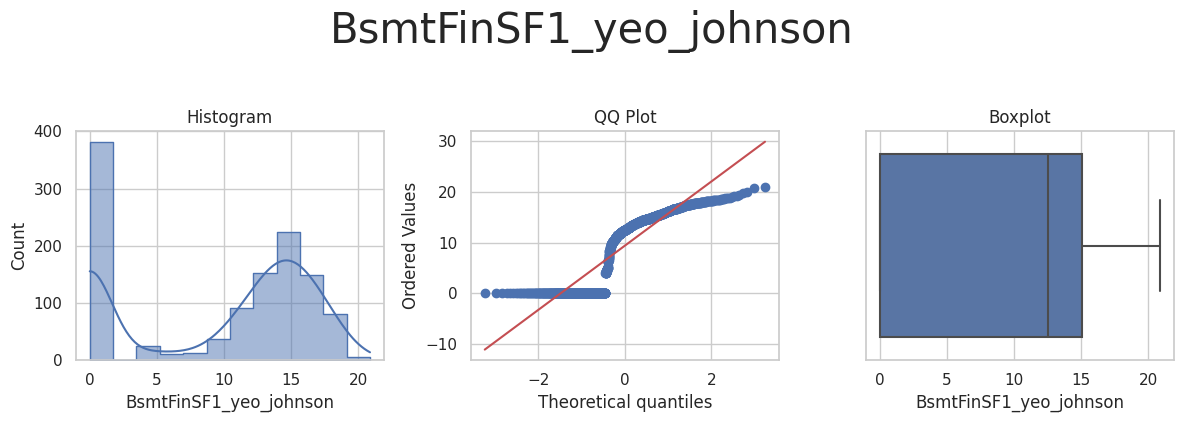



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_power', 'BsmtFinType1_yeo_johnson'] 



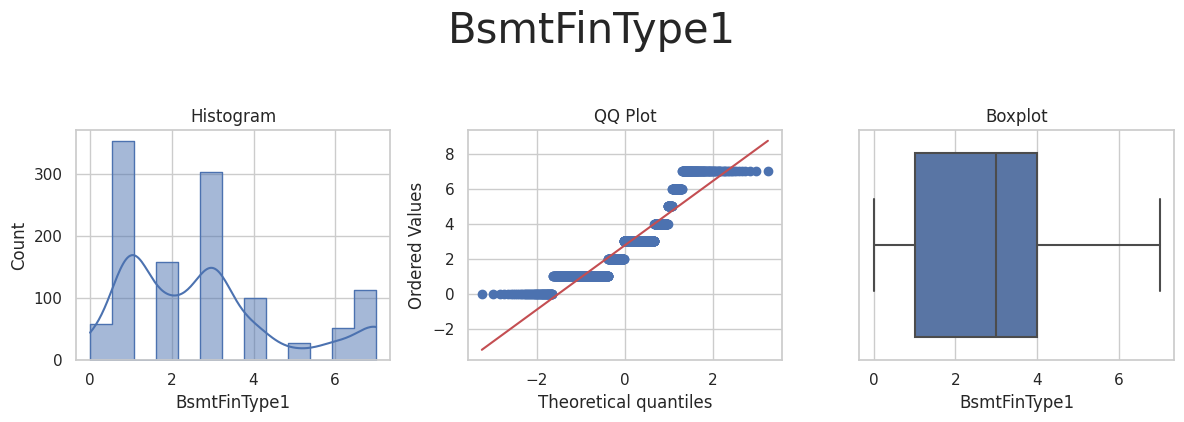

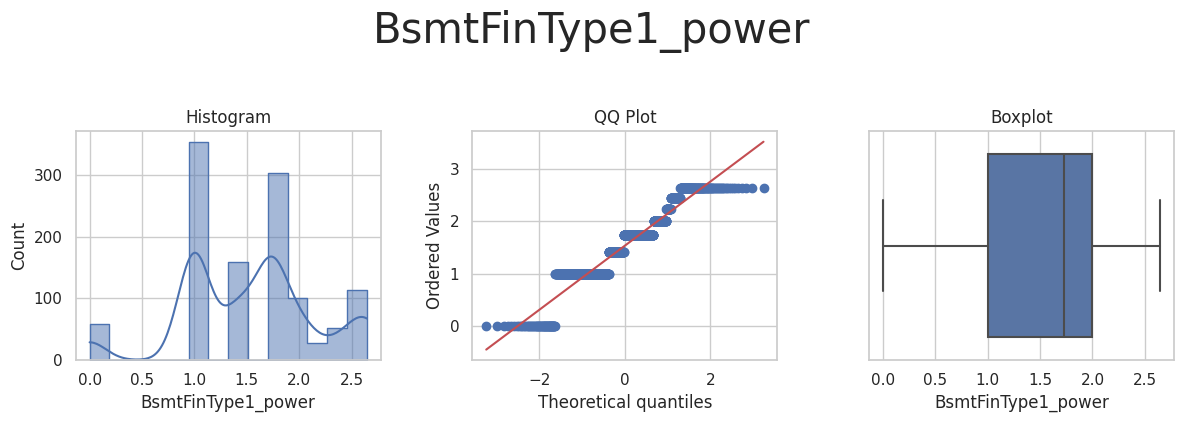

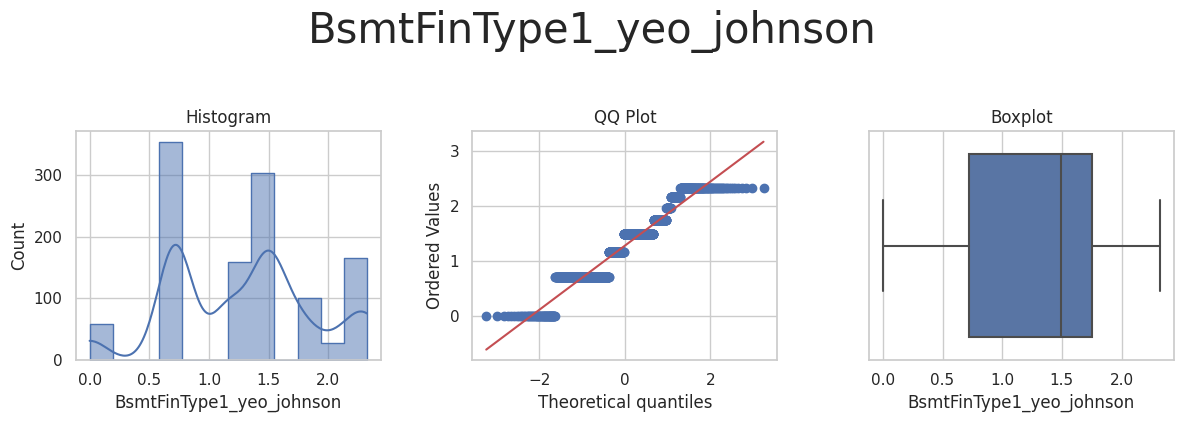



* Variable Analyzed: BsmtUnfSF
* Applied transformation: ['BsmtUnfSF_power', 'BsmtUnfSF_yeo_johnson'] 



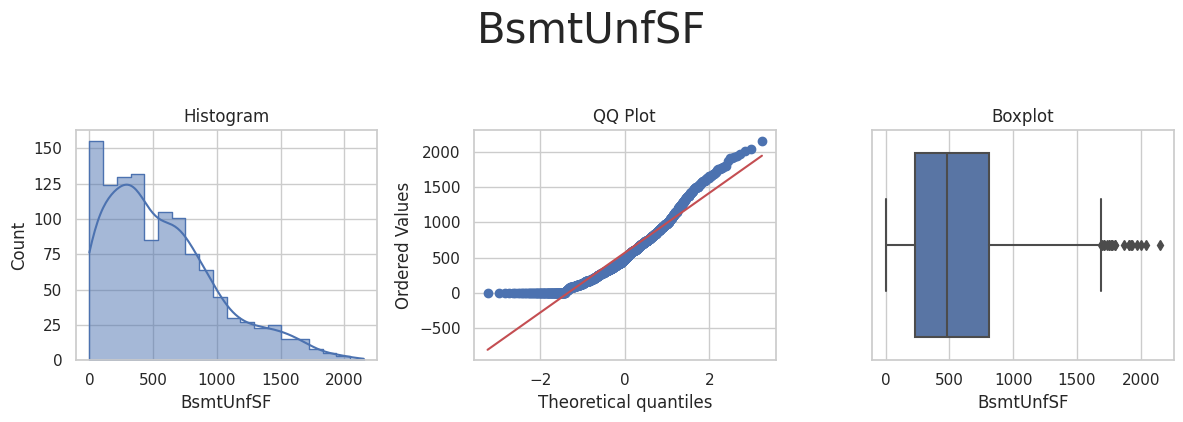

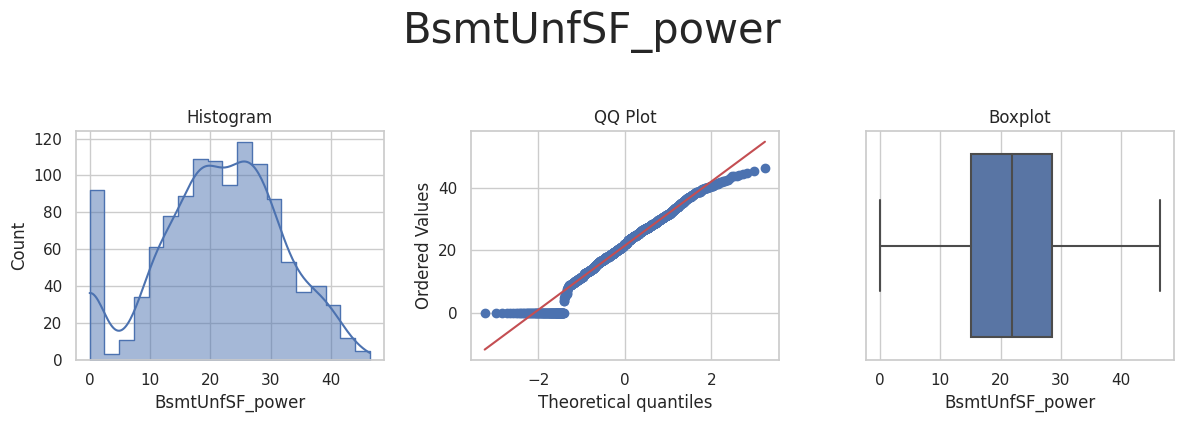

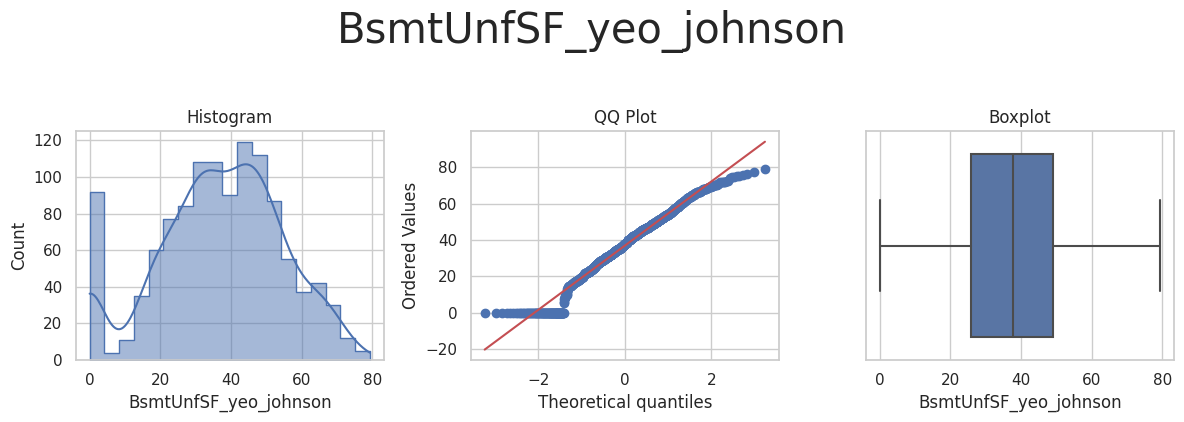



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



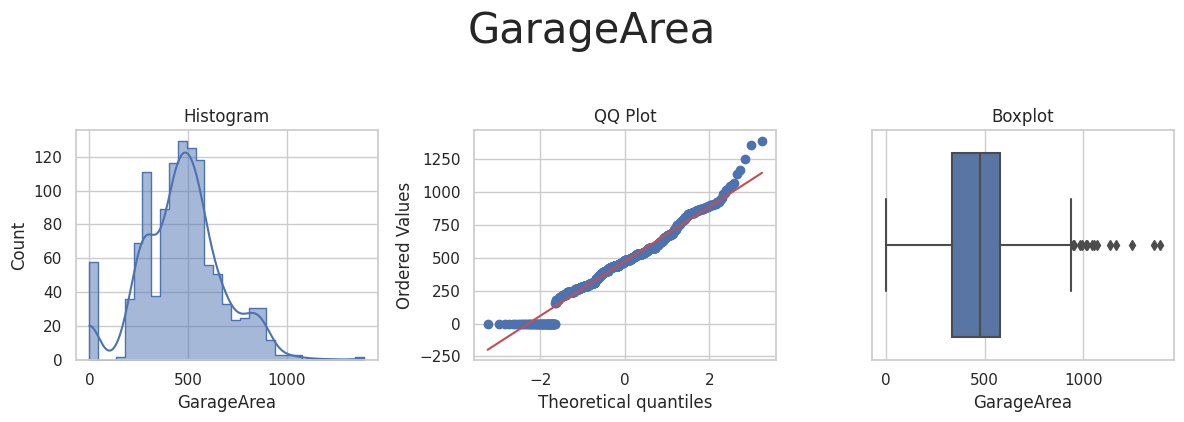

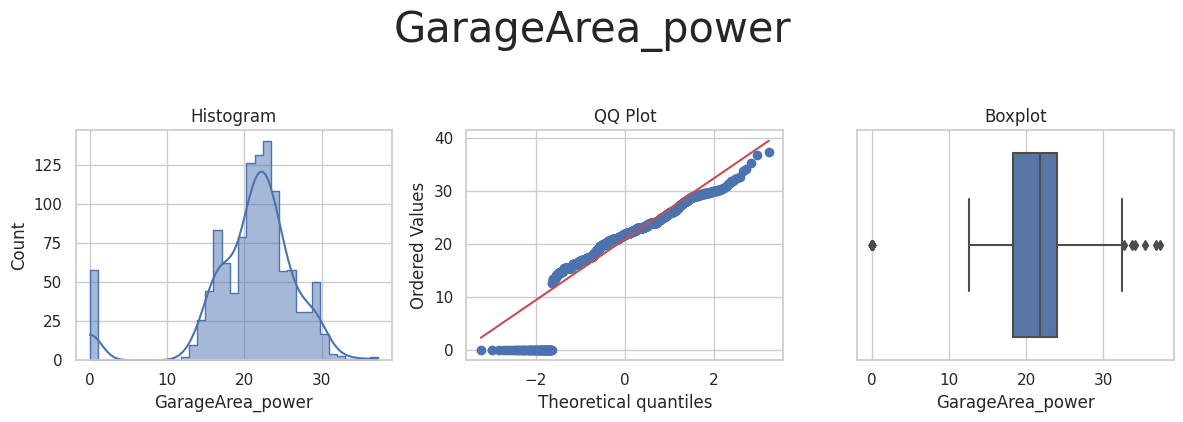

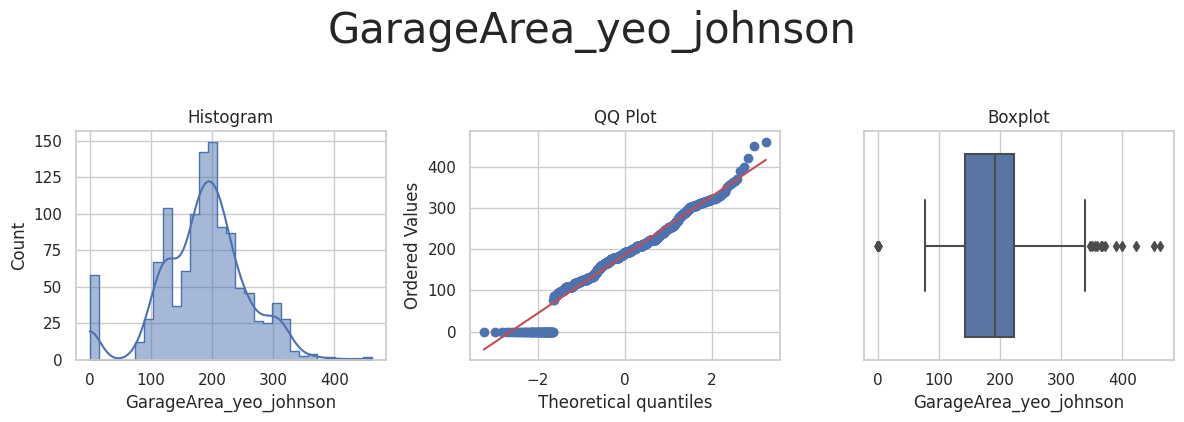



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_power', 'GarageFinish_yeo_johnson'] 



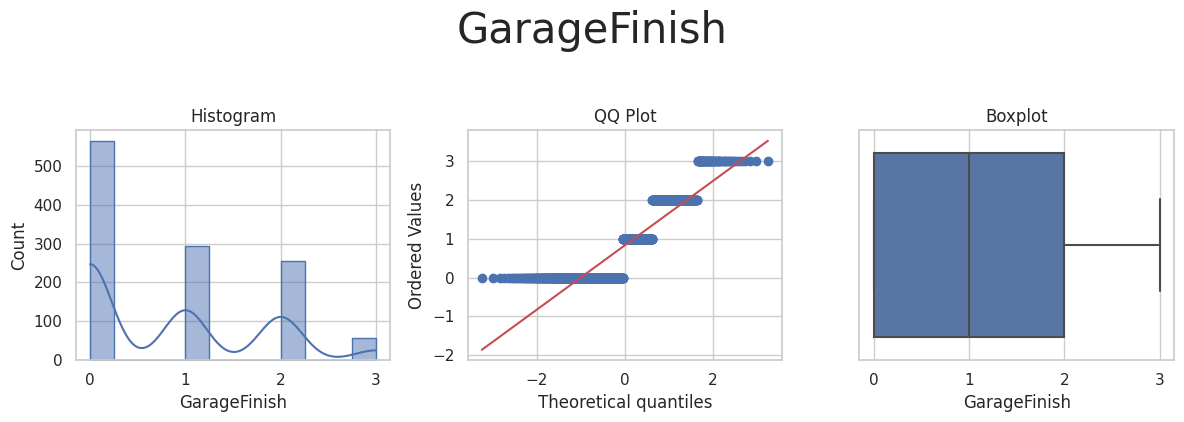

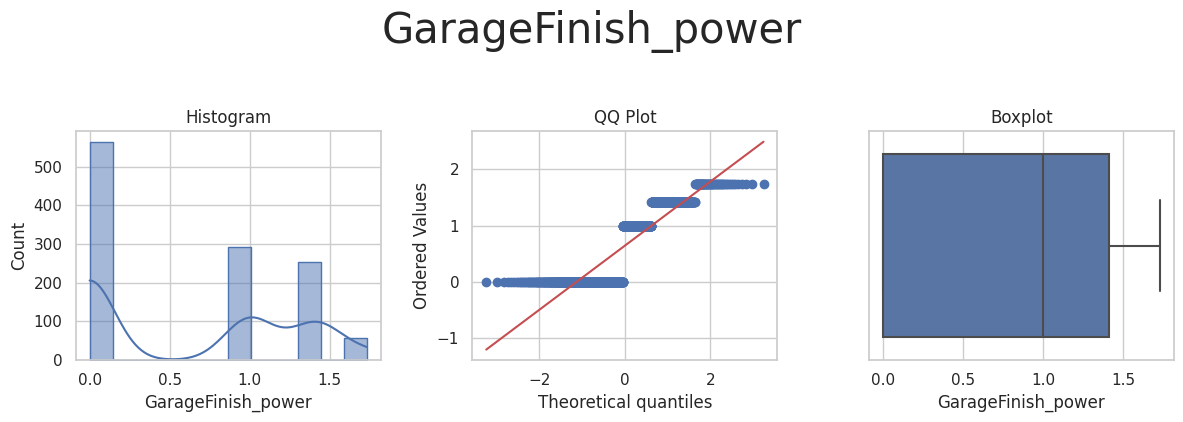

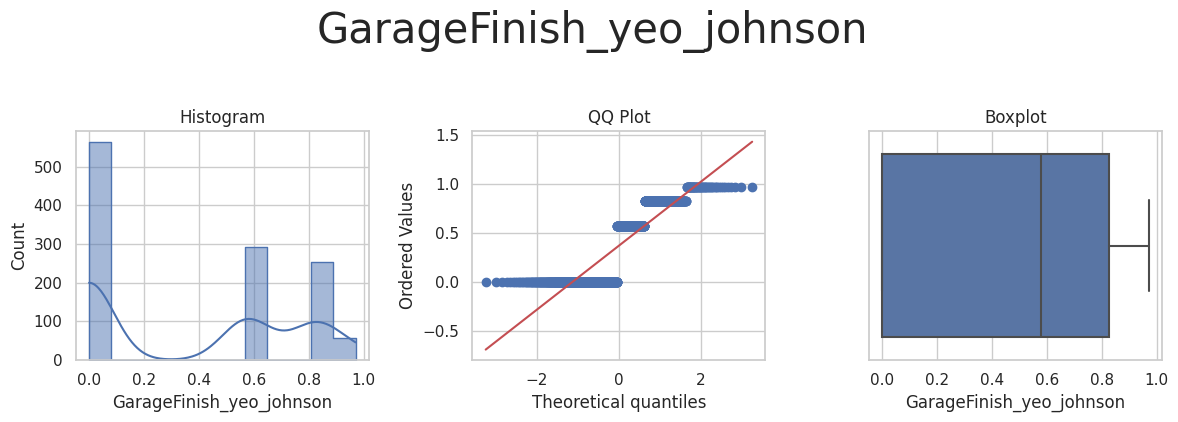



* Variable Analyzed: GarageYrBlt
* Applied transformation: ['GarageYrBlt_power', 'GarageYrBlt_yeo_johnson'] 



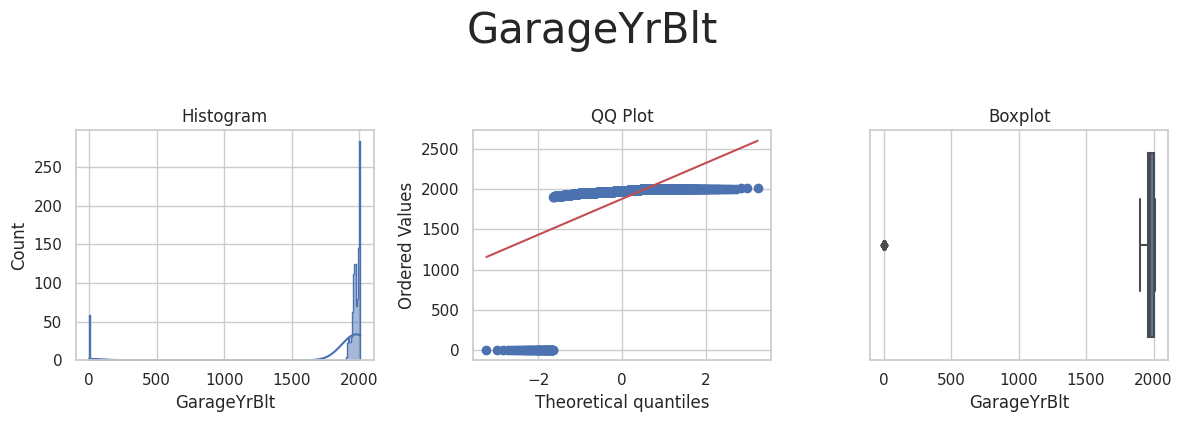

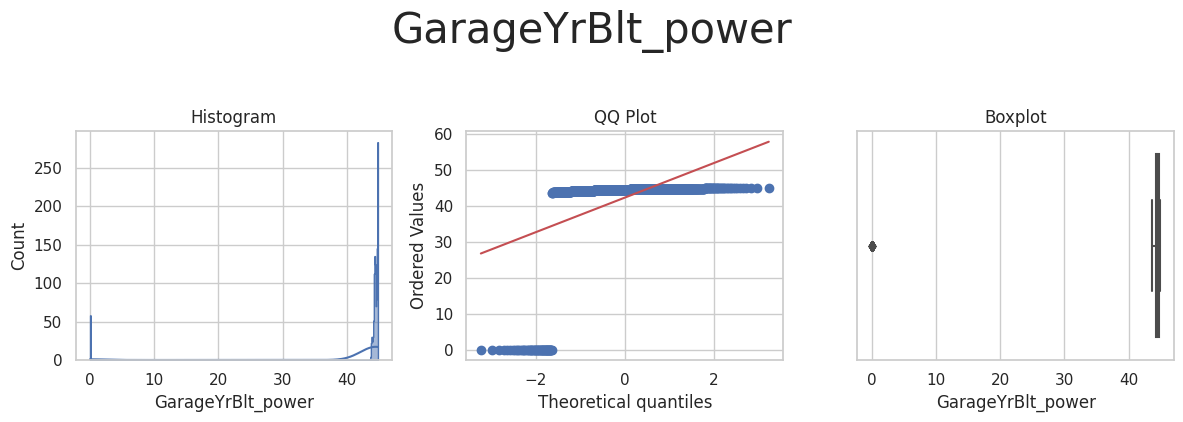

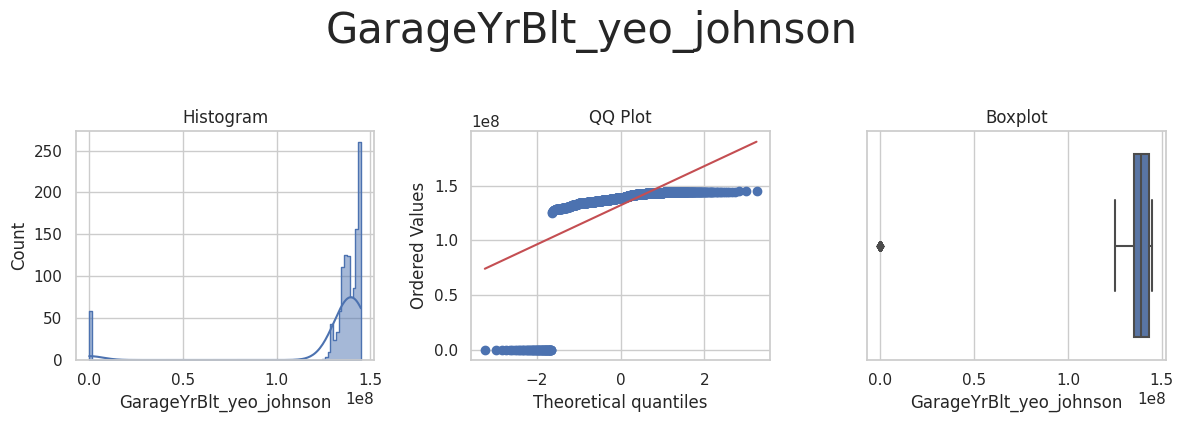



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



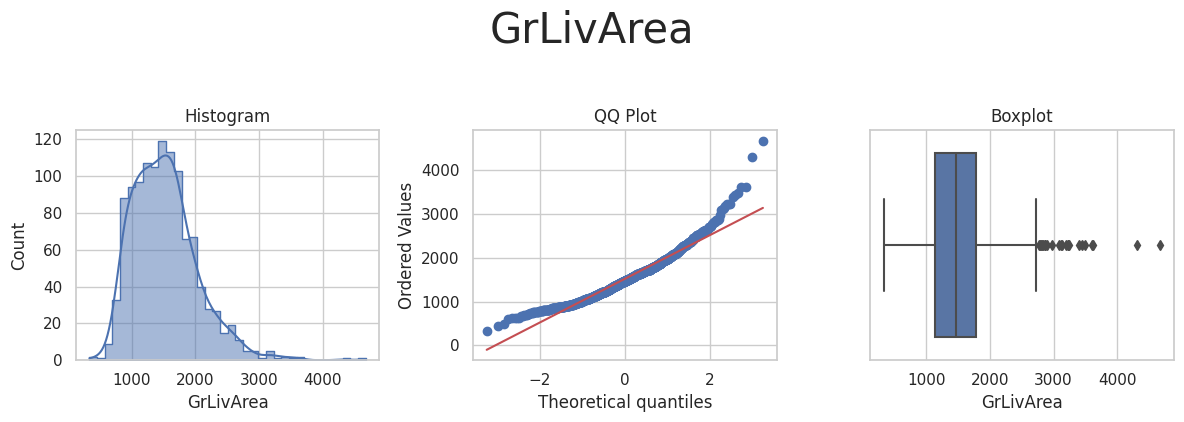

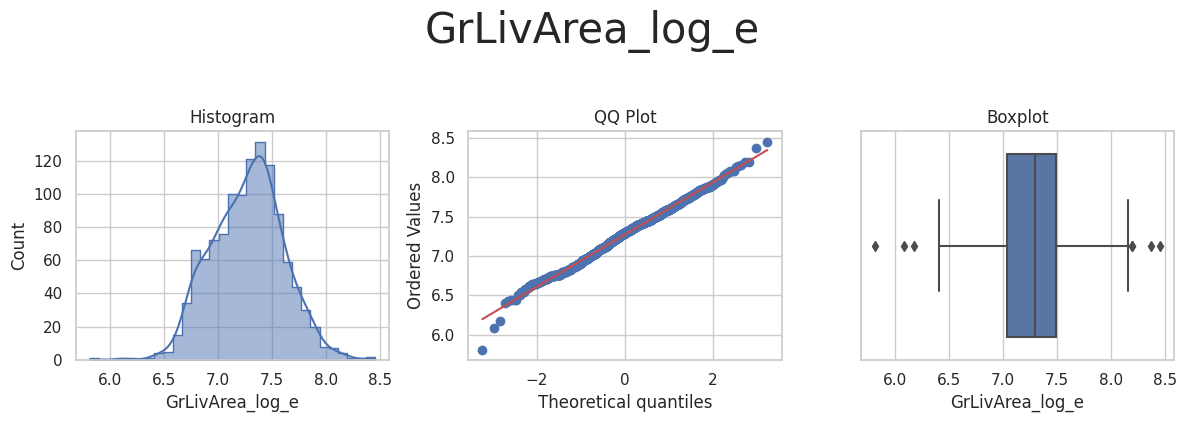

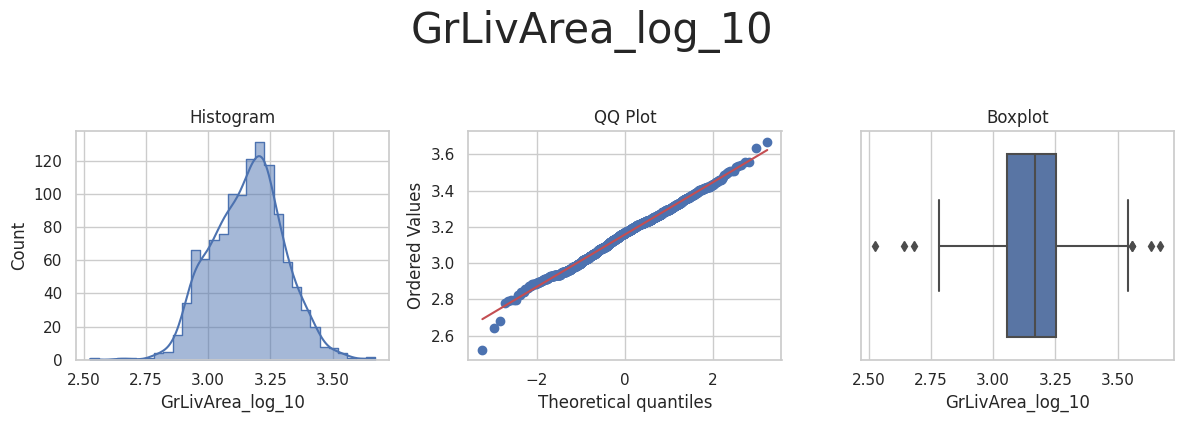

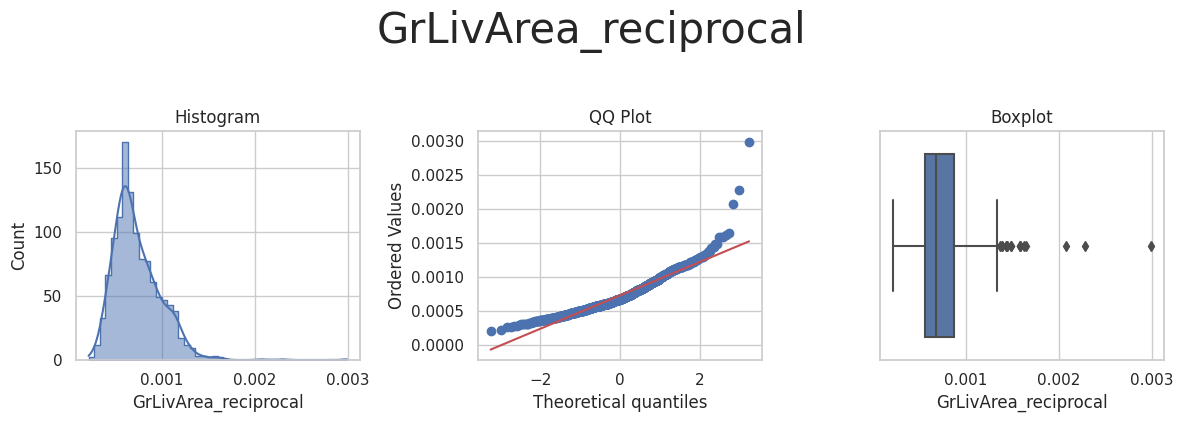

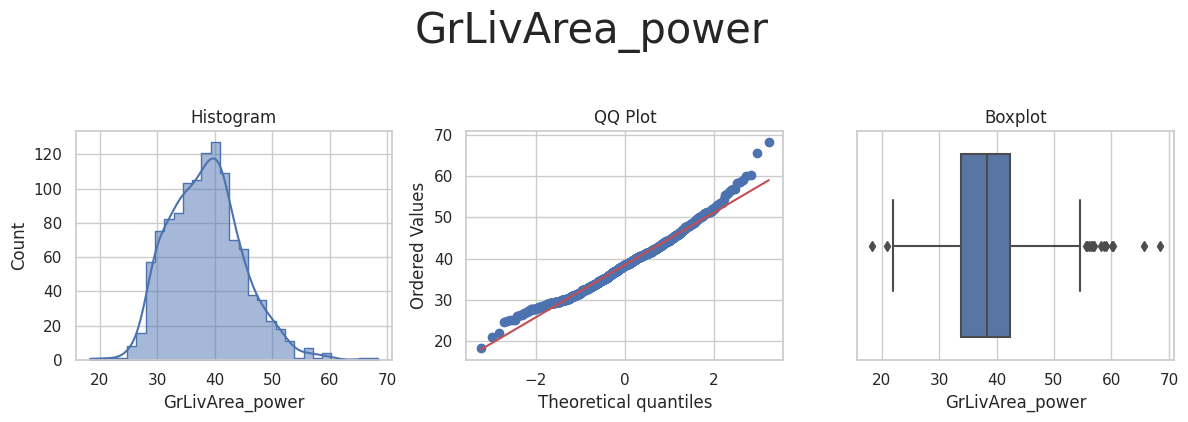

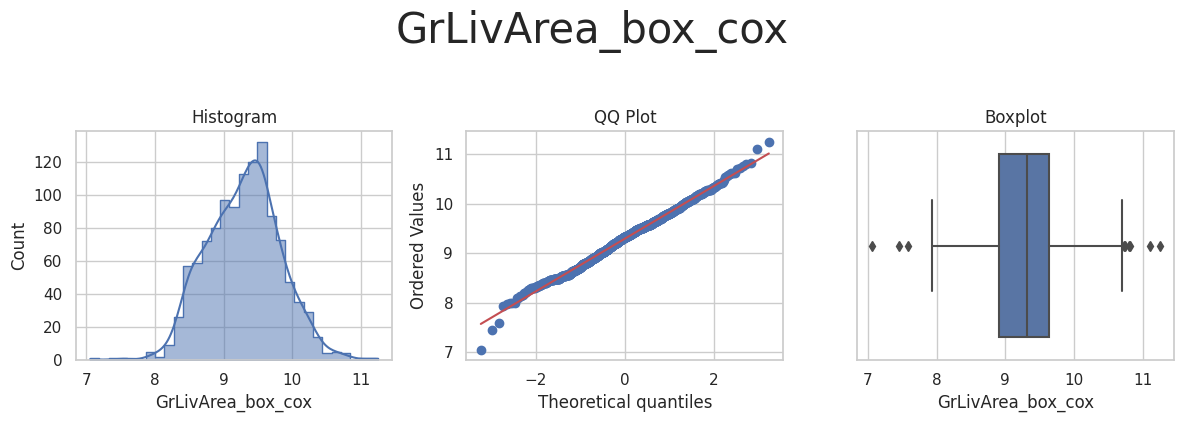

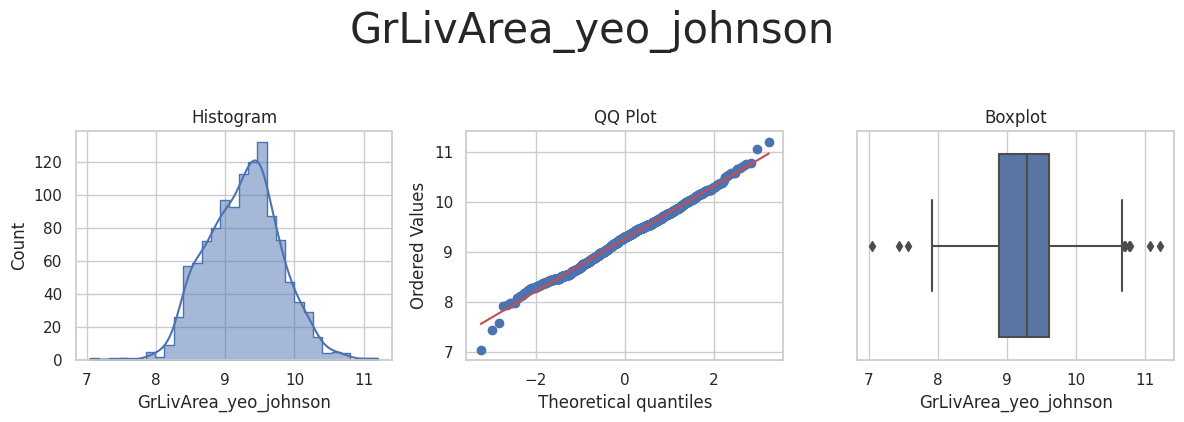



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_power', 'KitchenQual_yeo_johnson'] 



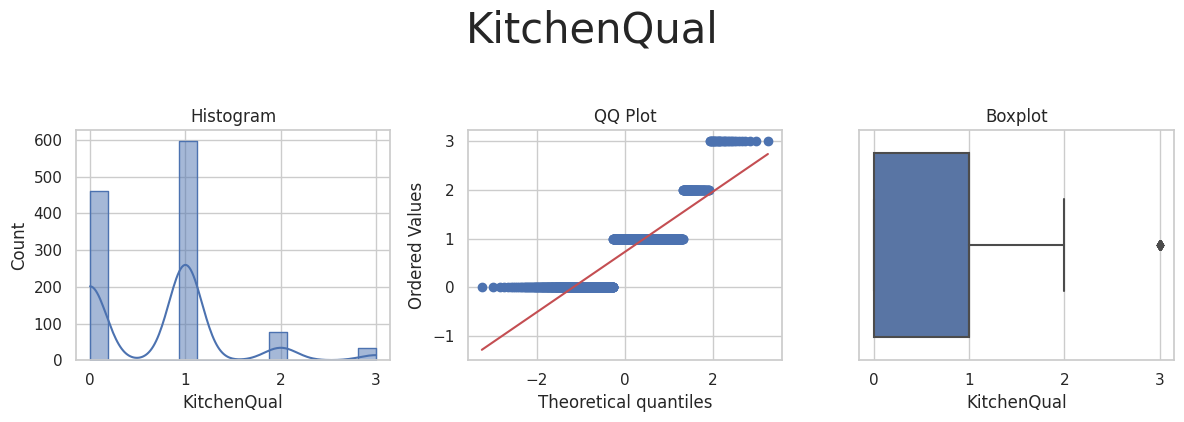

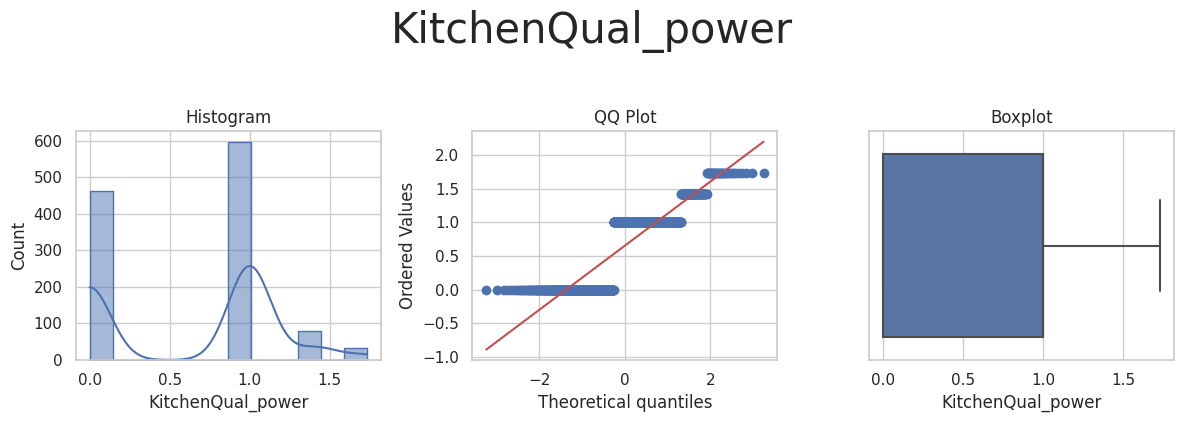

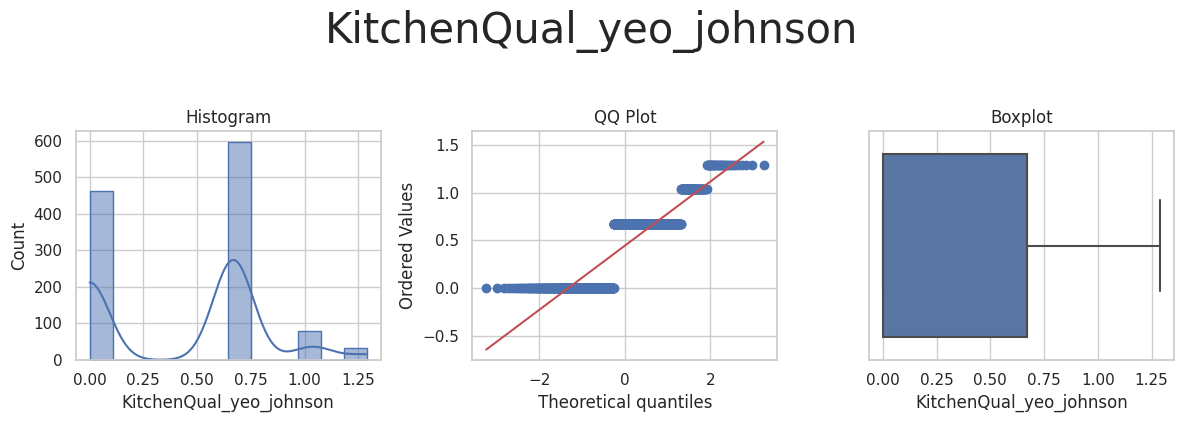



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



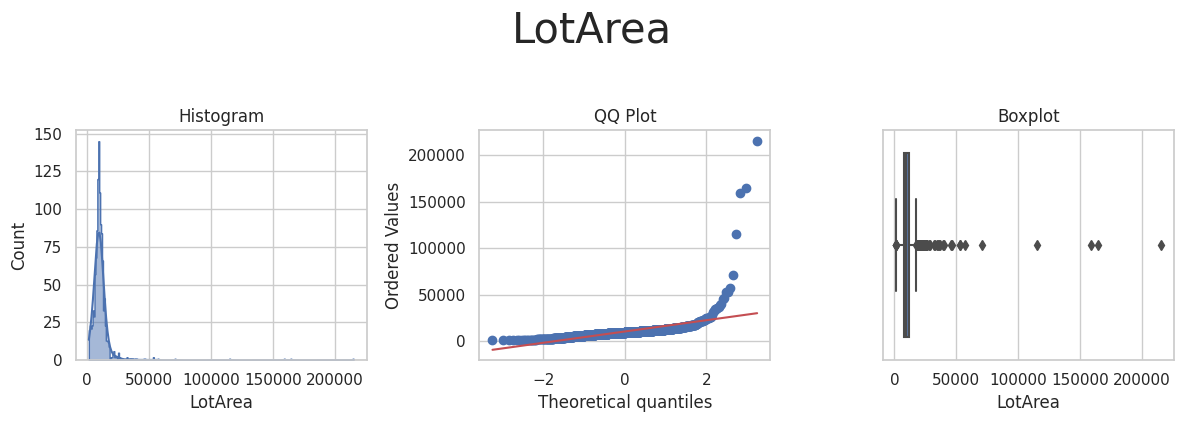

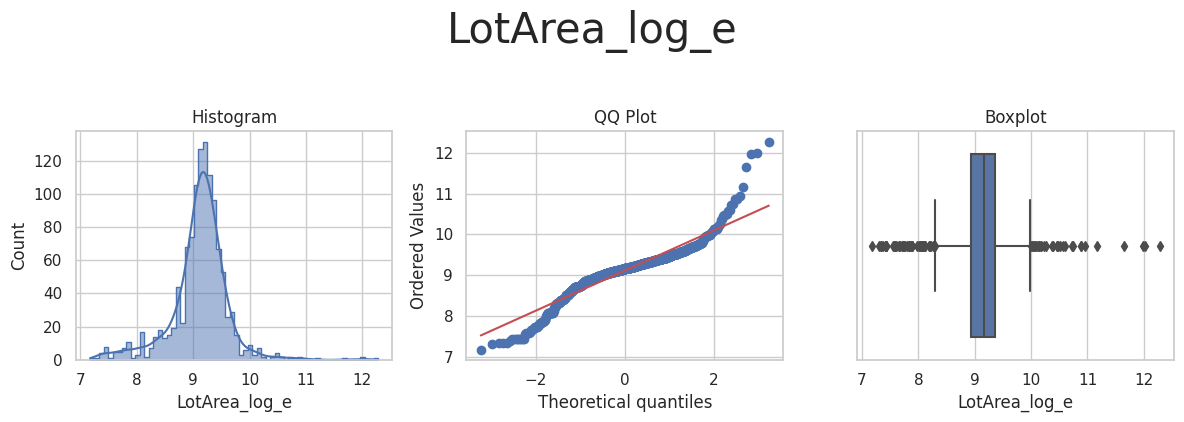

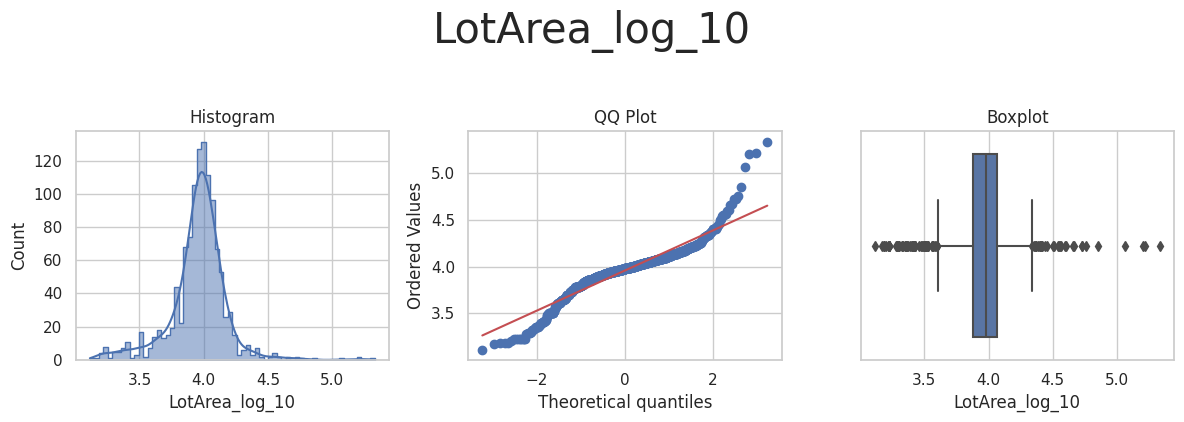

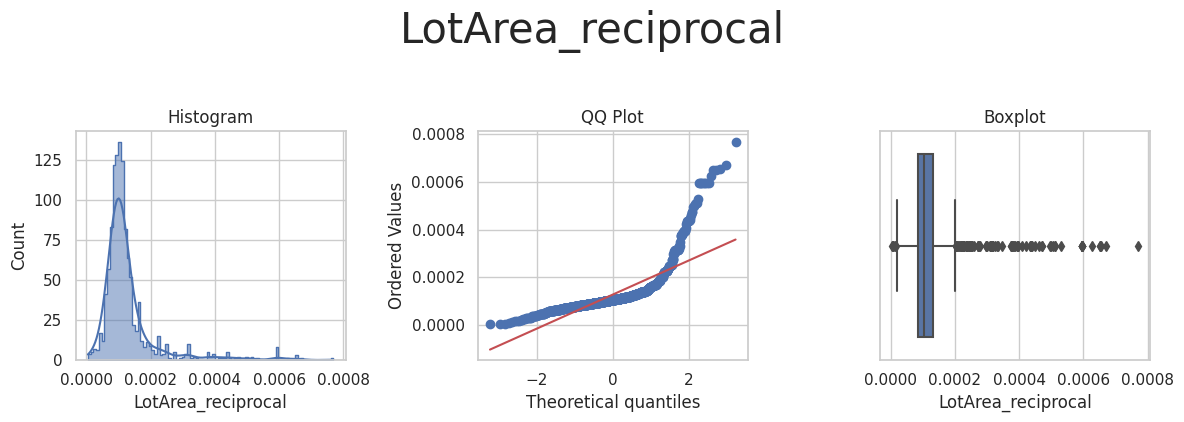

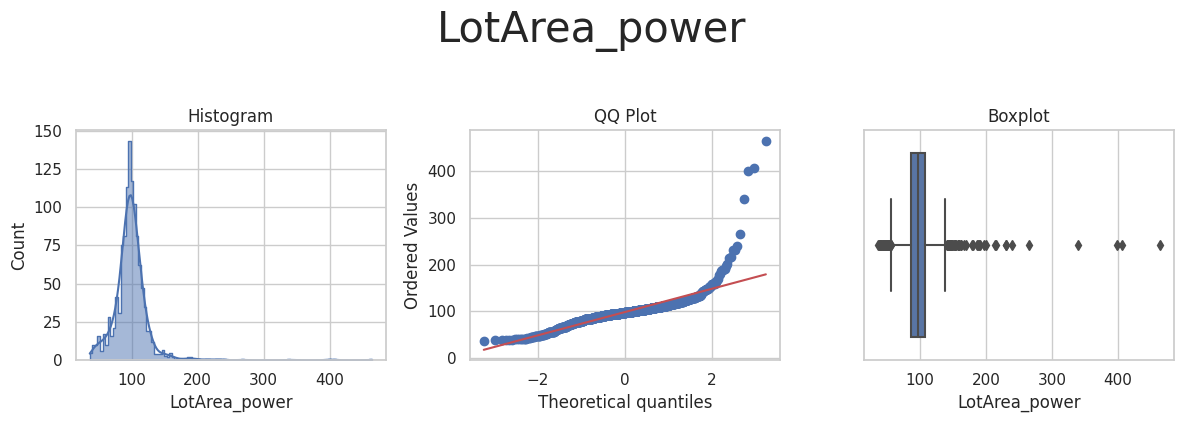

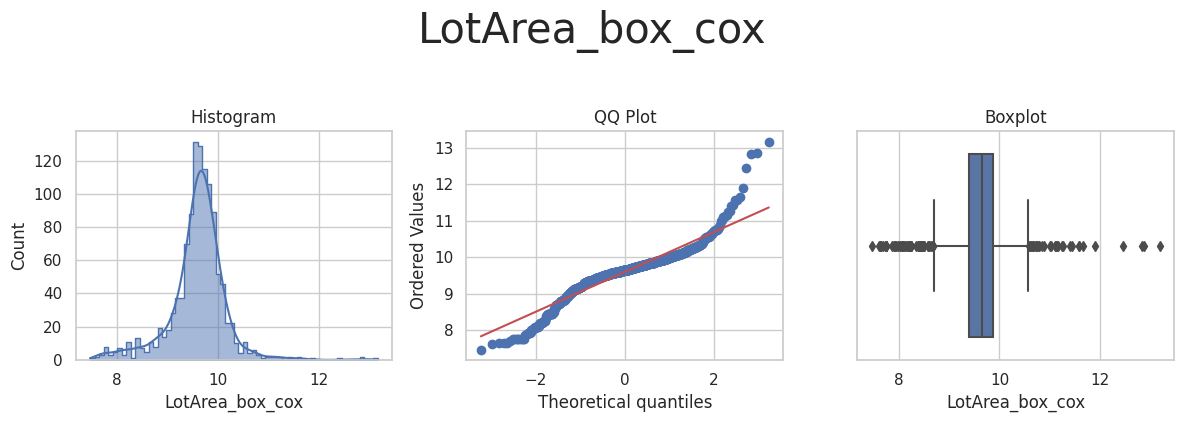

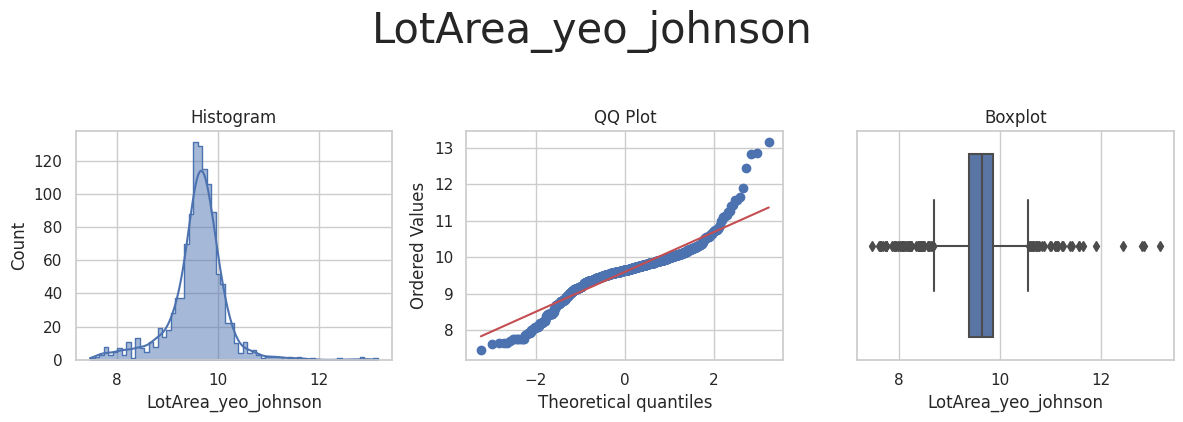



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



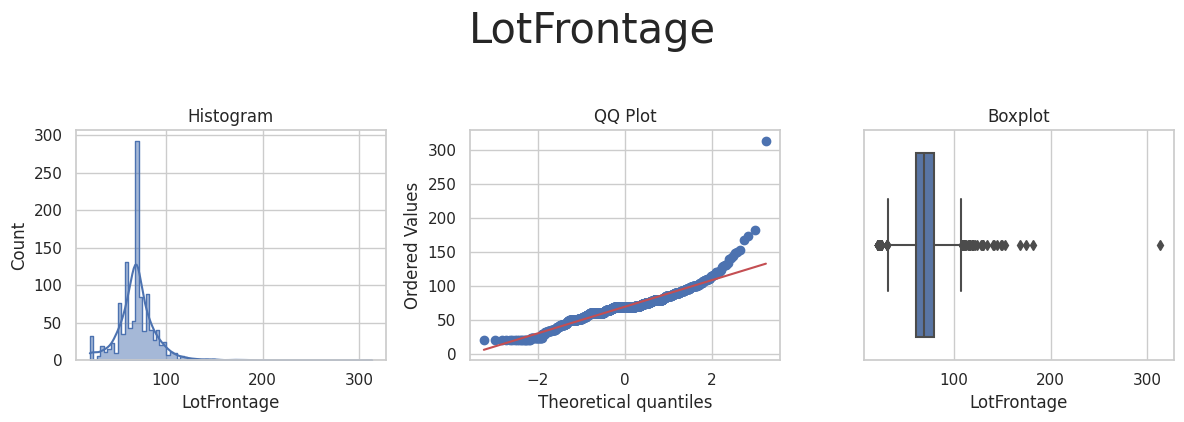

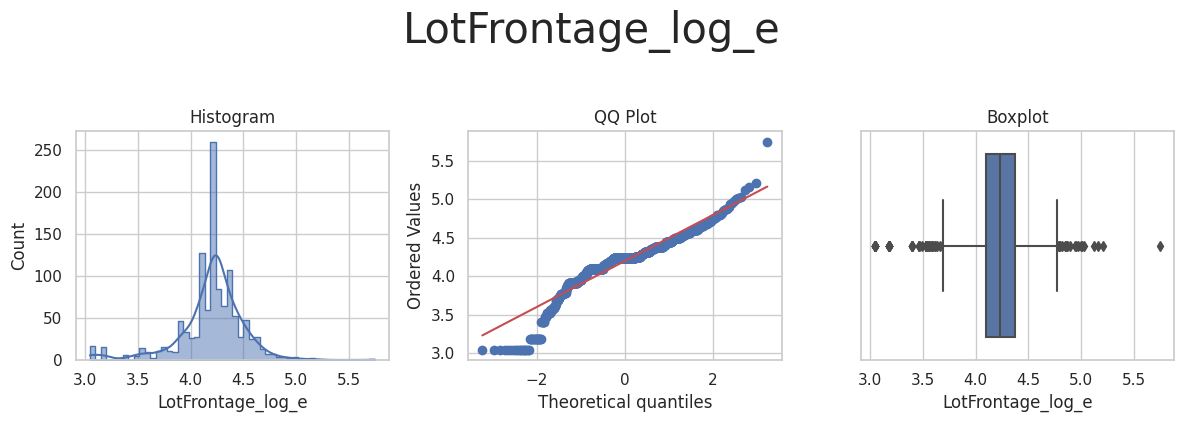

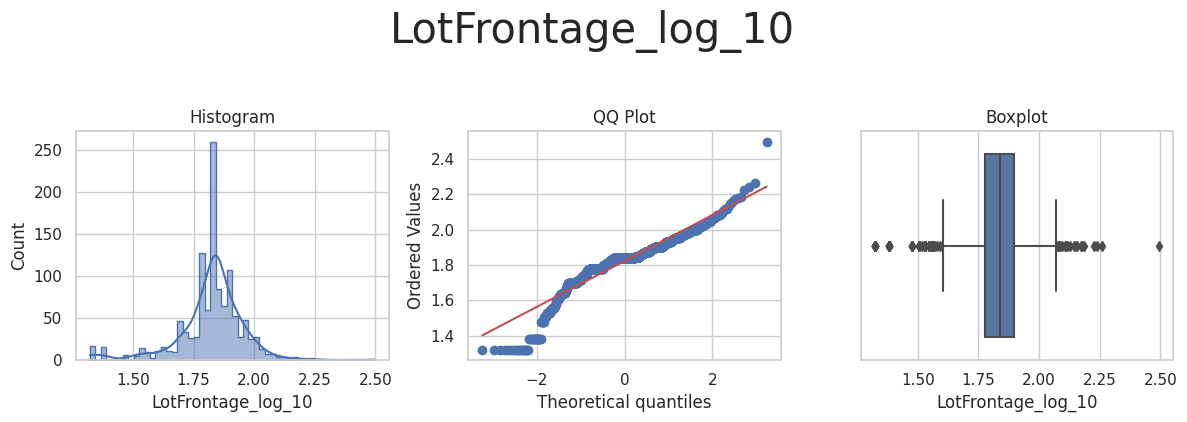

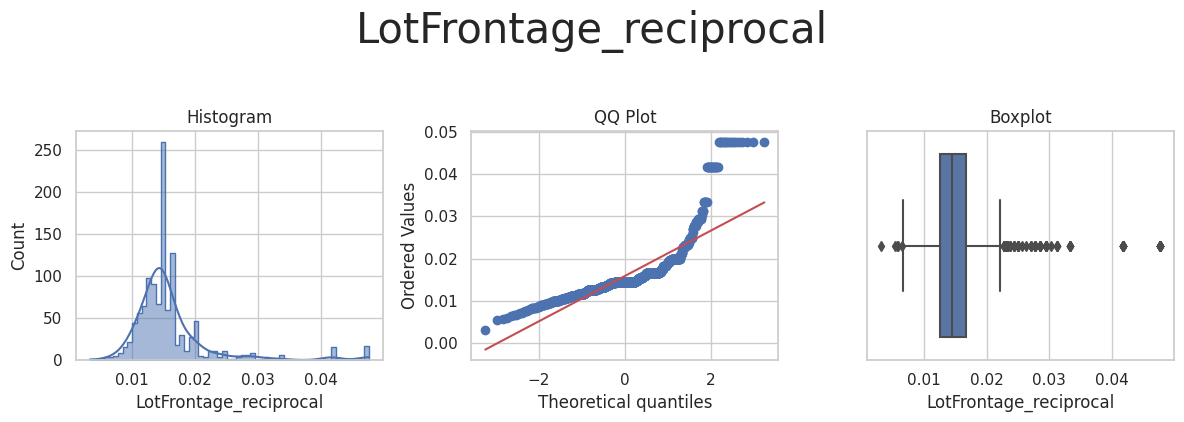

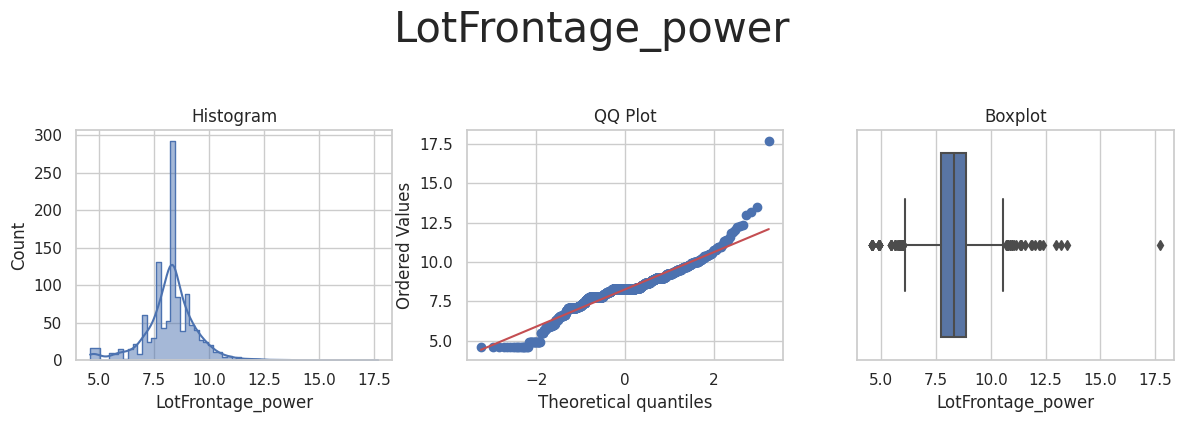

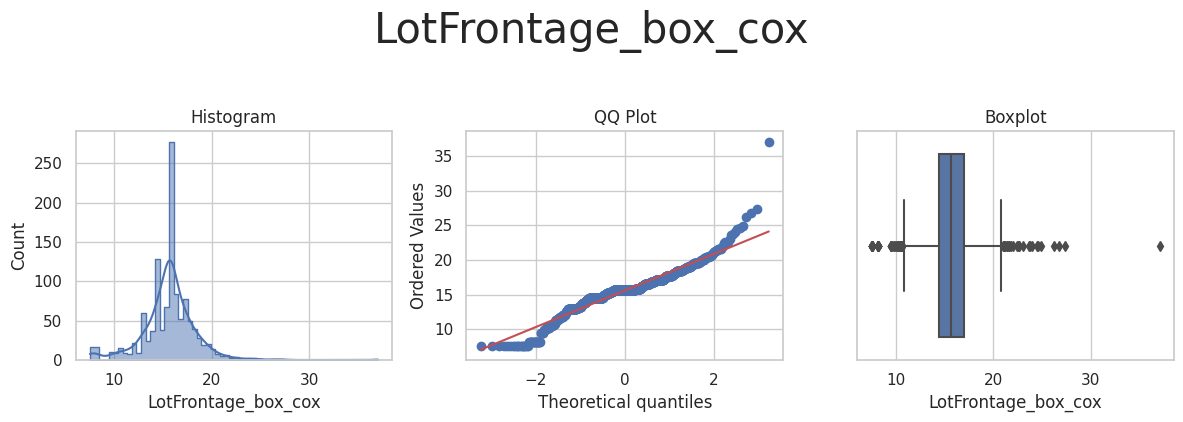

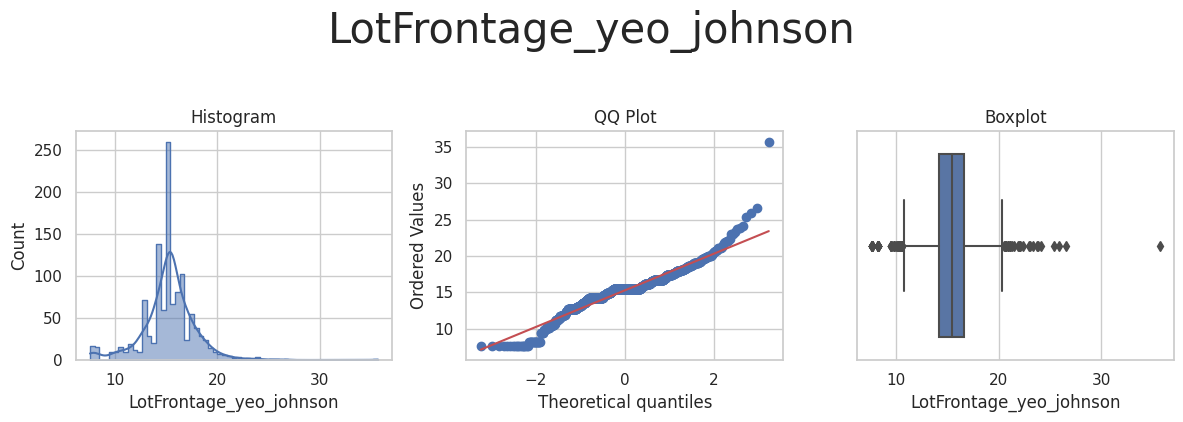



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_power', 'MasVnrArea_yeo_johnson'] 



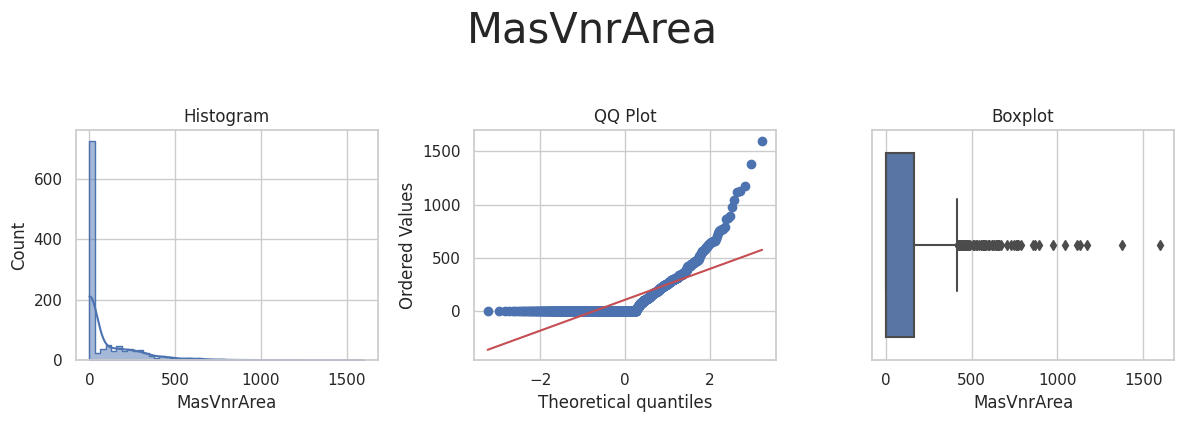

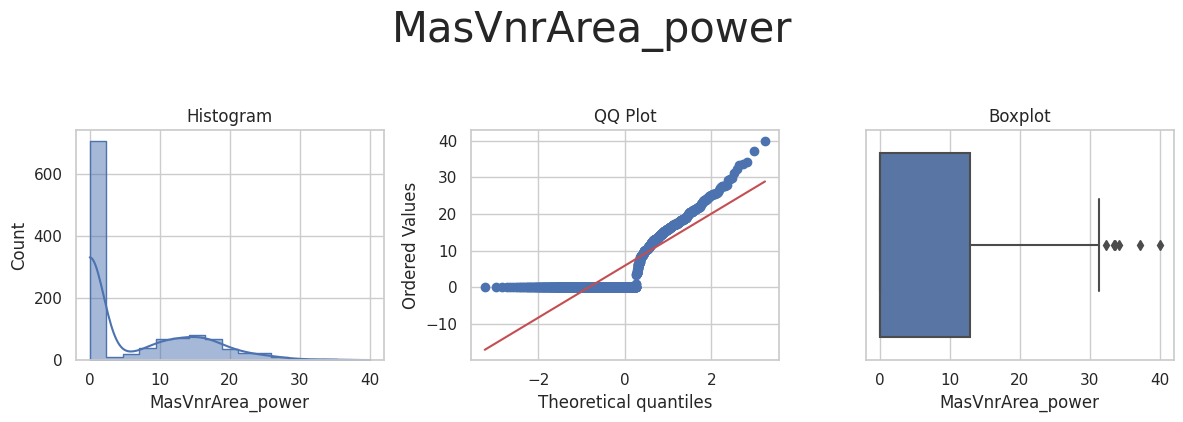

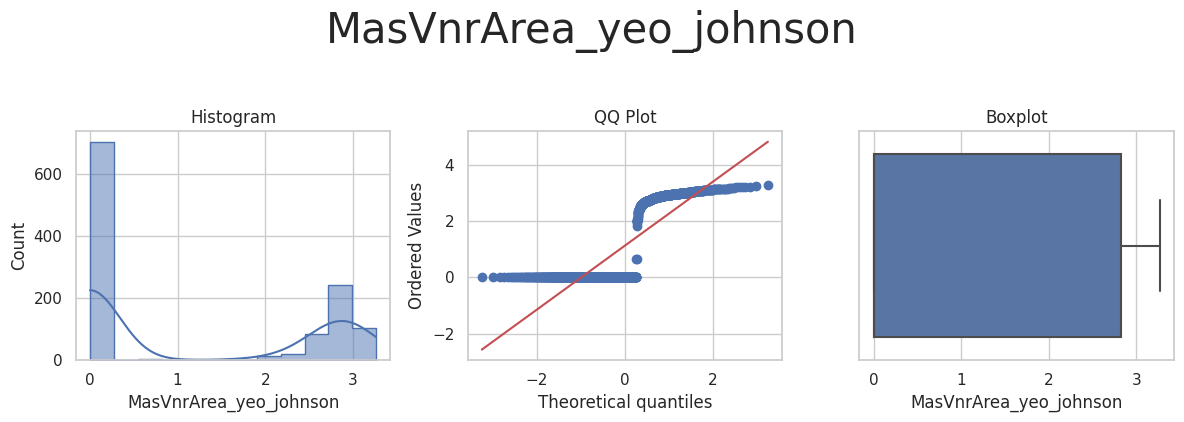



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_power', 'OpenPorchSF_yeo_johnson'] 



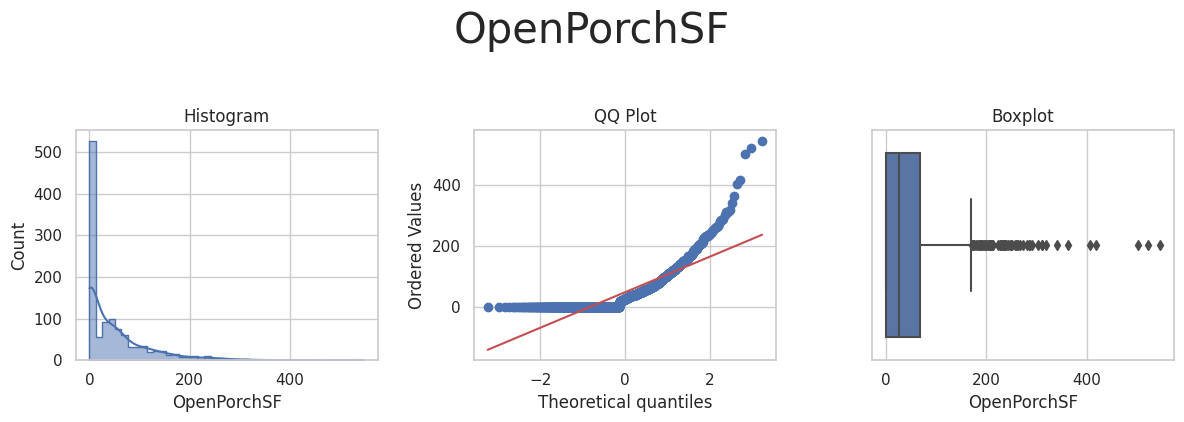

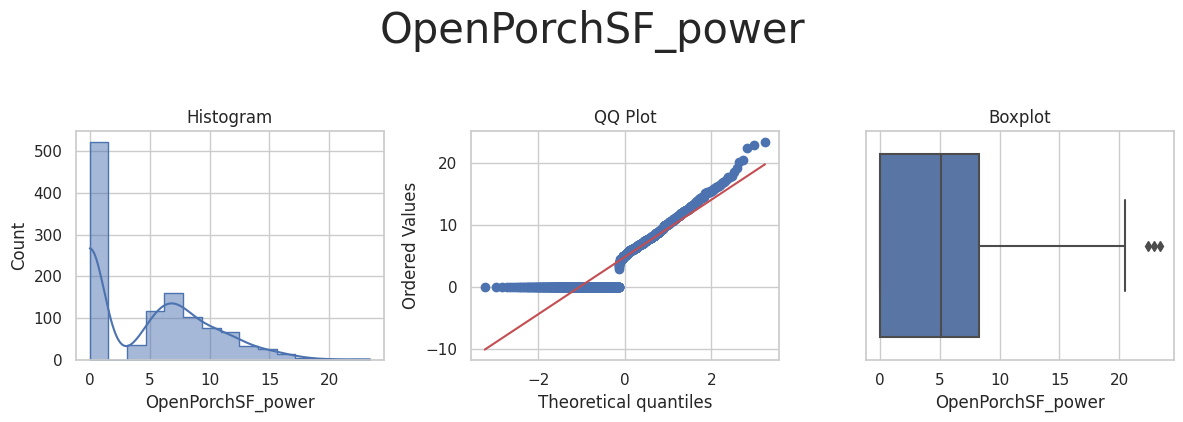

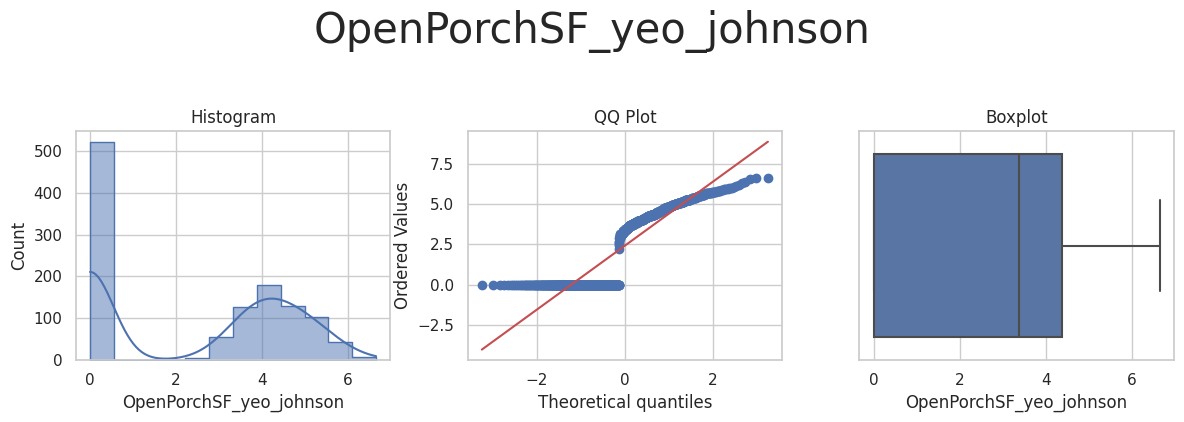



* Variable Analyzed: OverallCond
* Applied transformation: ['OverallCond_log_e', 'OverallCond_log_10', 'OverallCond_reciprocal', 'OverallCond_power', 'OverallCond_box_cox', 'OverallCond_yeo_johnson'] 



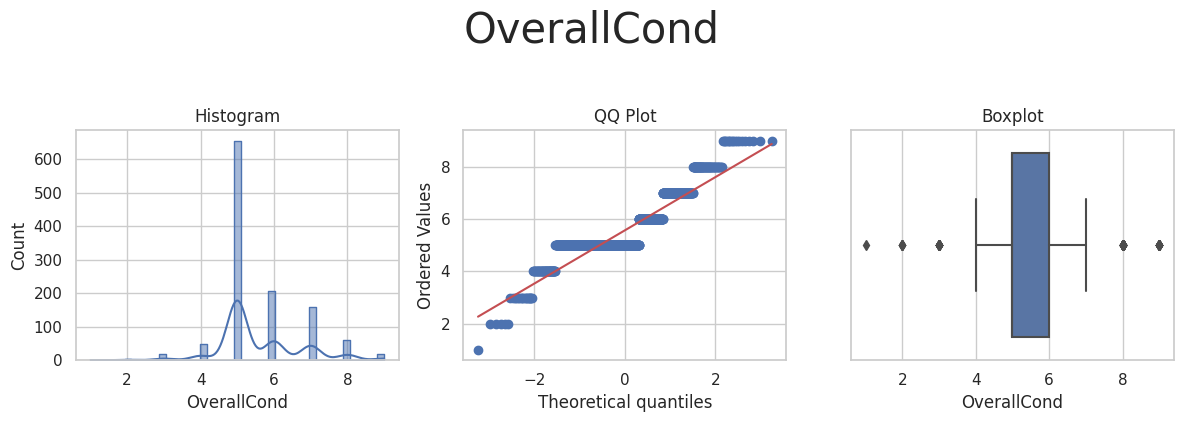

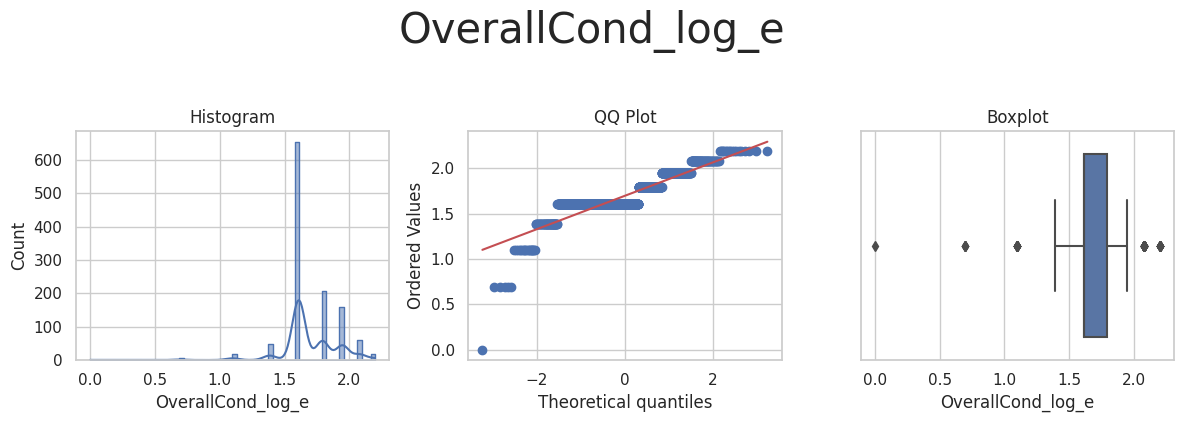

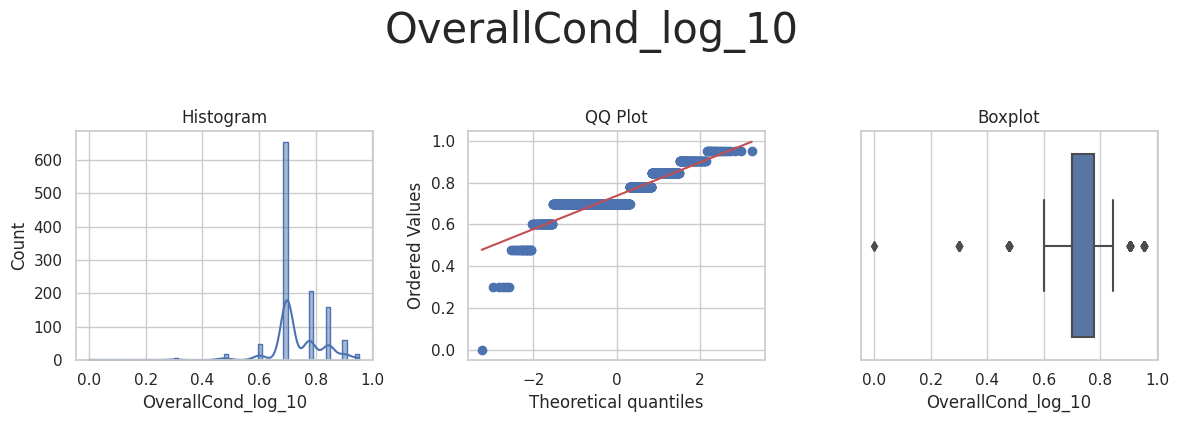

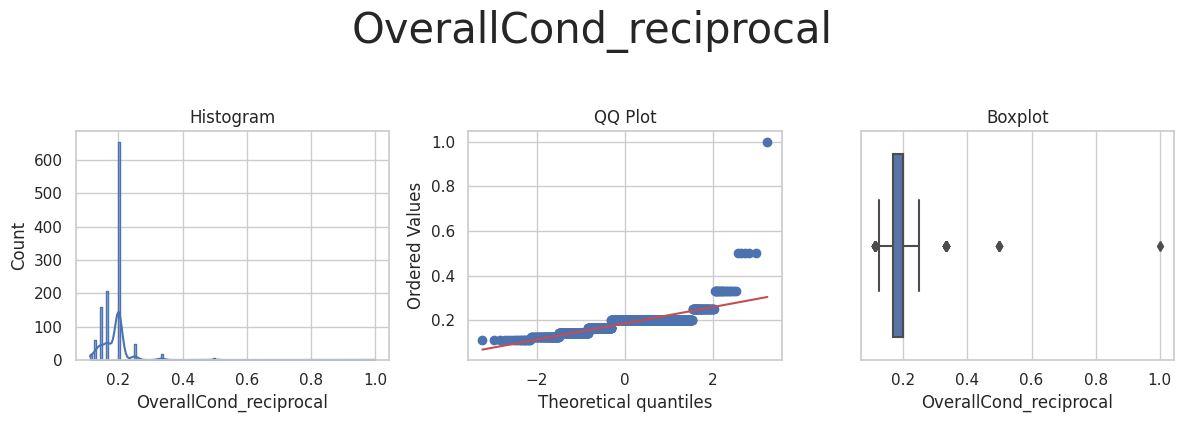

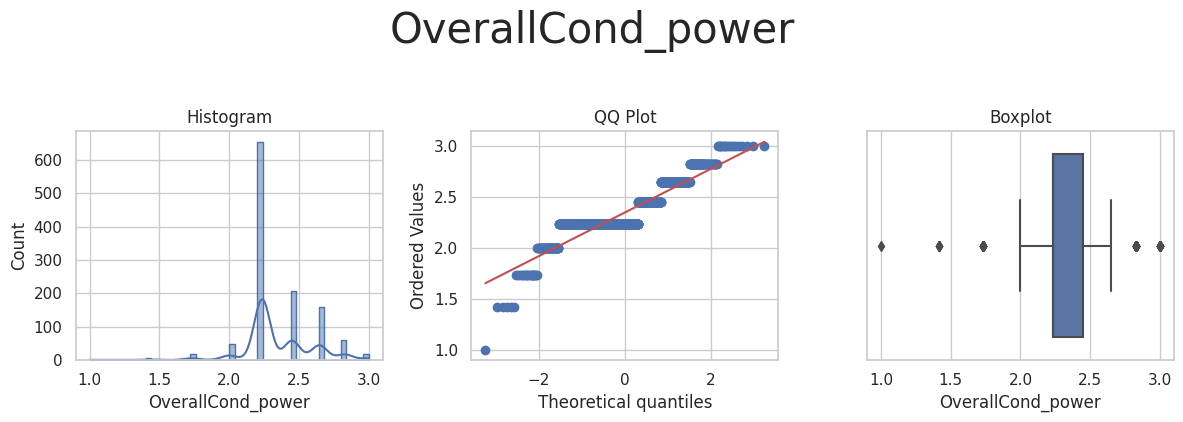

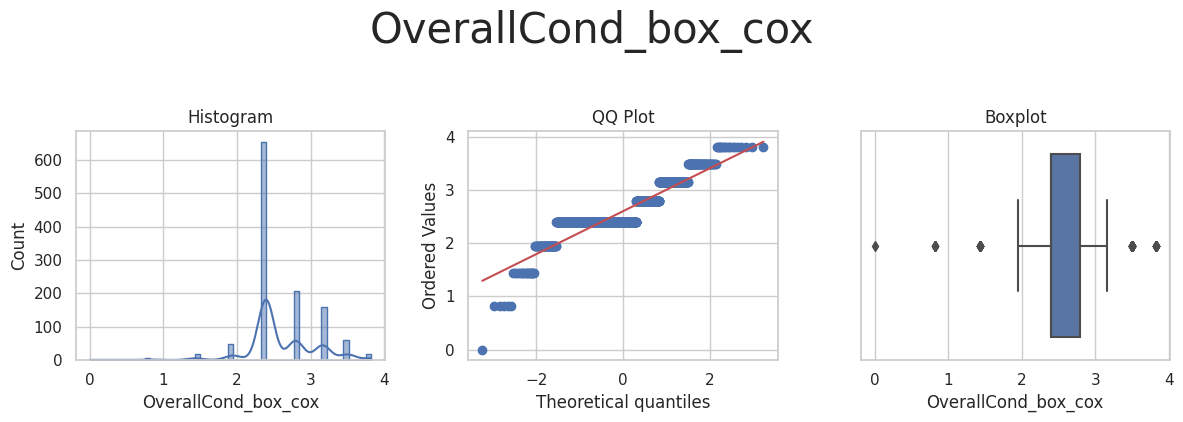

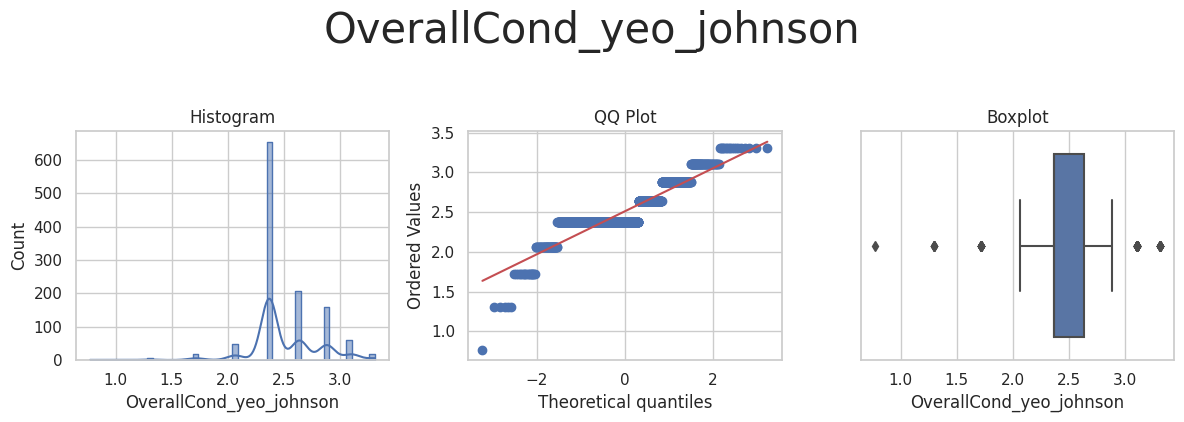



* Variable Analyzed: OverallQual
* Applied transformation: ['OverallQual_log_e', 'OverallQual_log_10', 'OverallQual_reciprocal', 'OverallQual_power', 'OverallQual_box_cox', 'OverallQual_yeo_johnson'] 



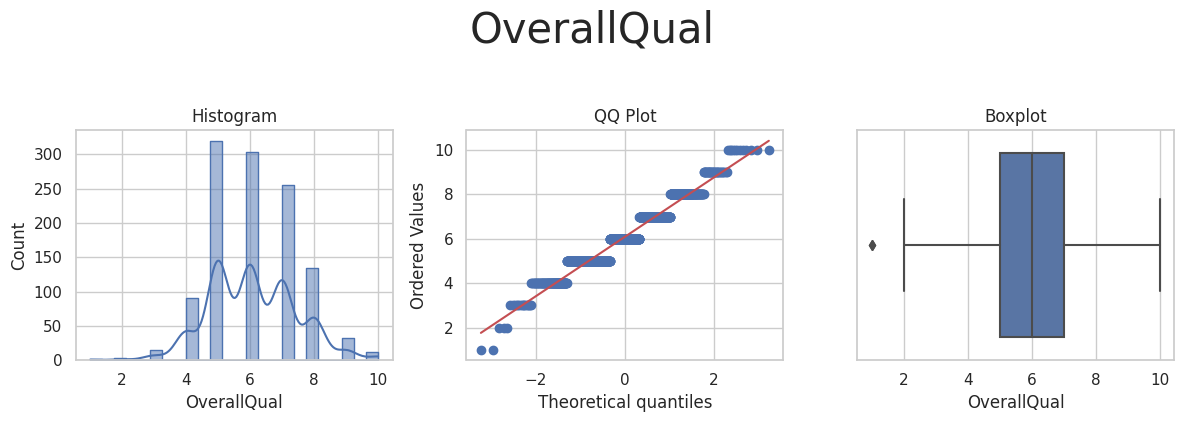

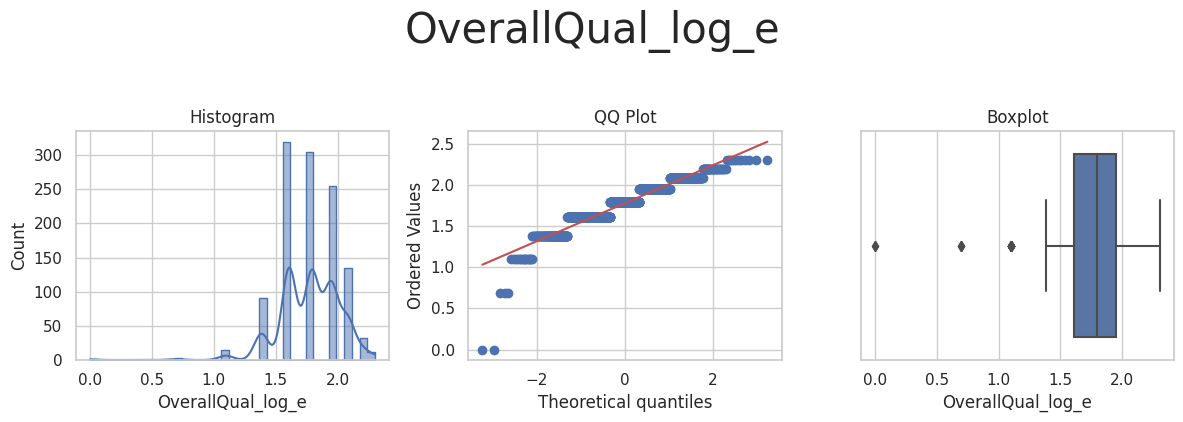

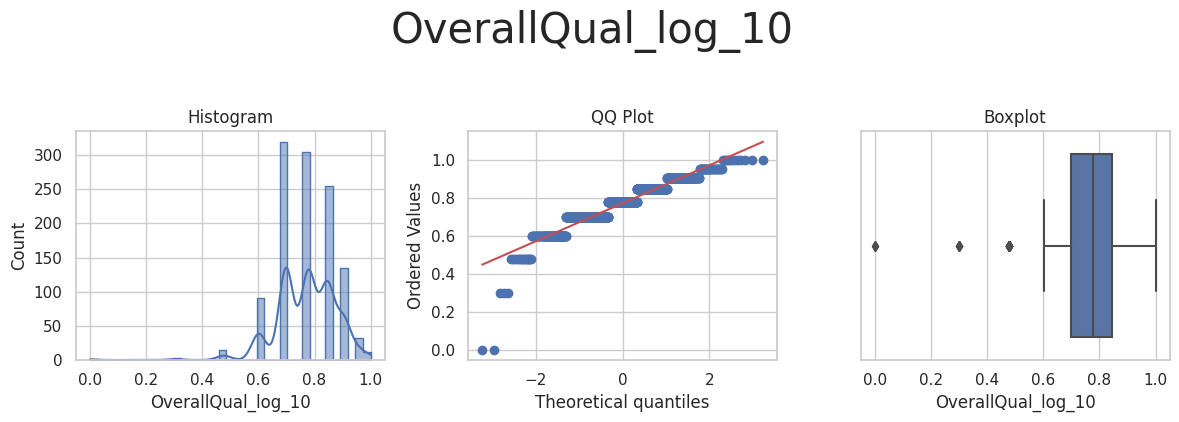

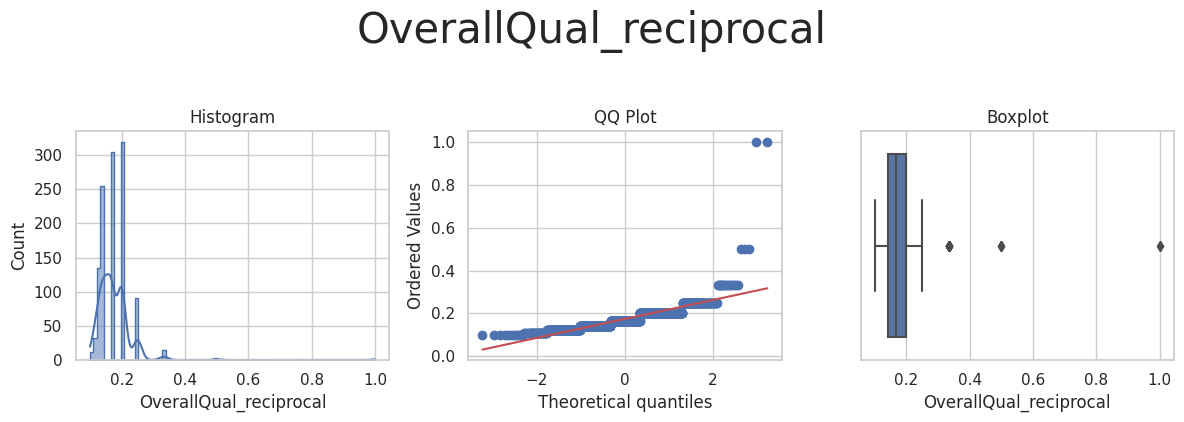

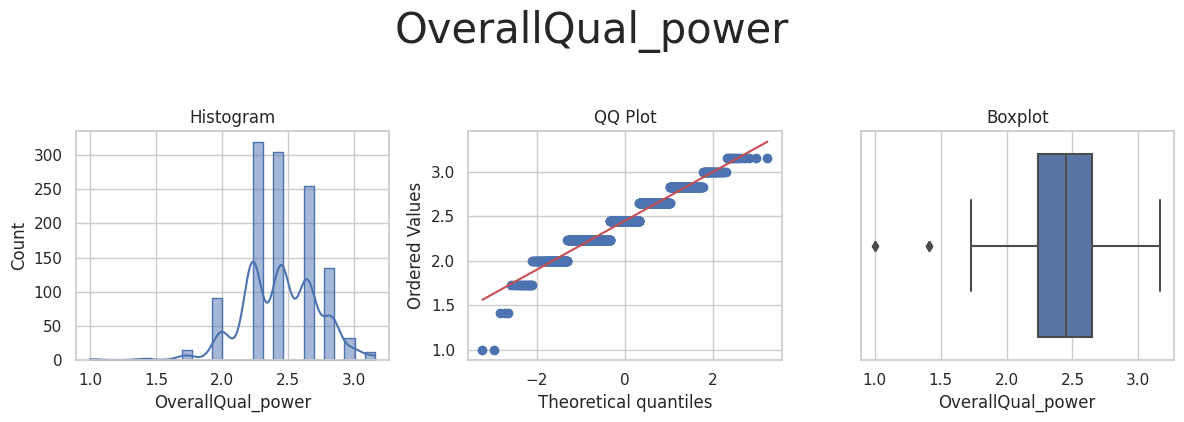

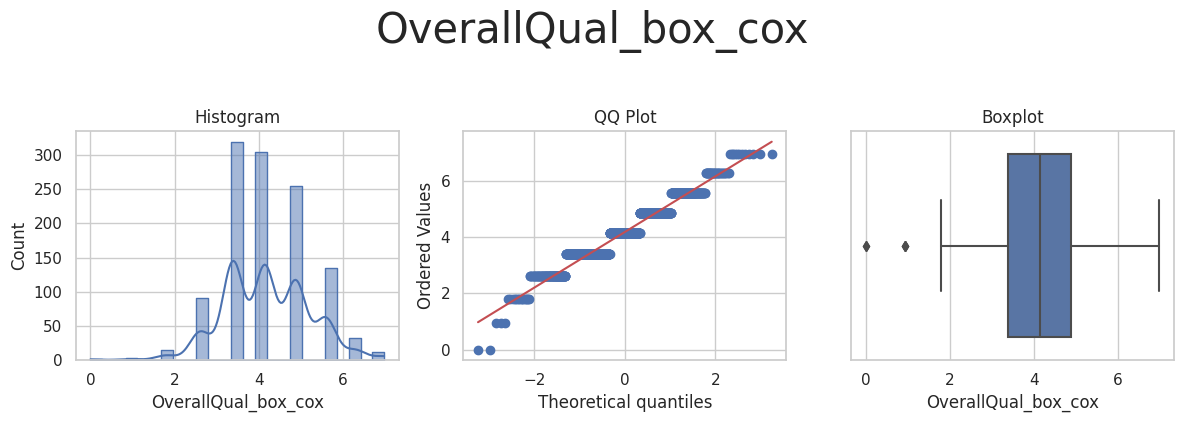

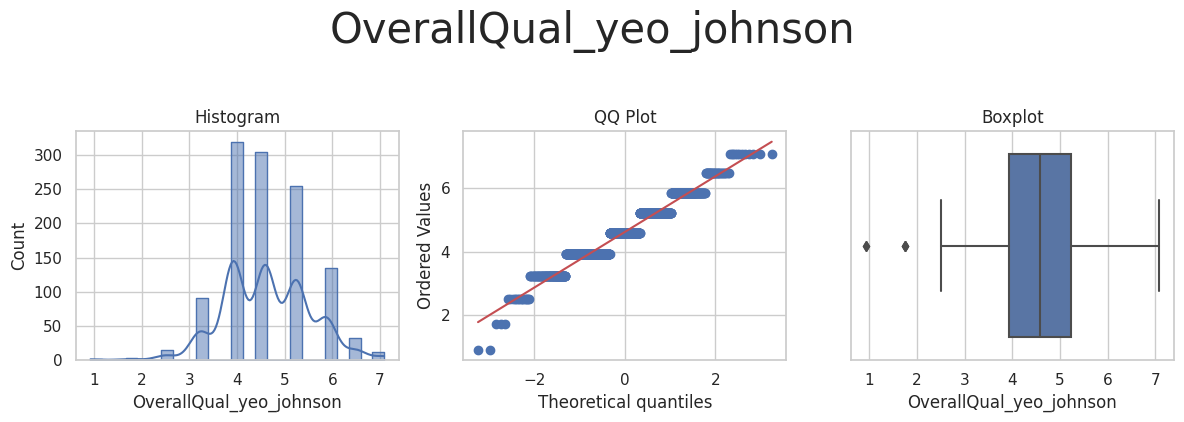



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



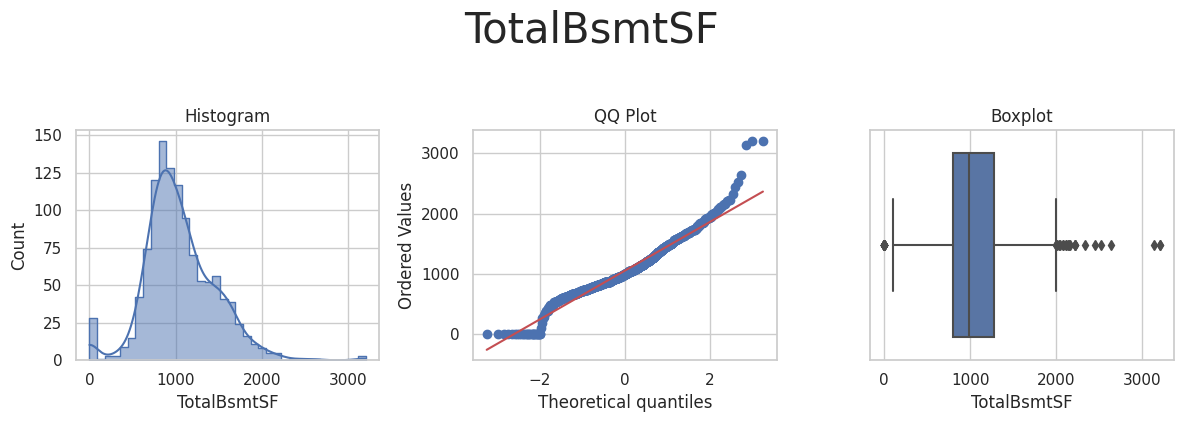

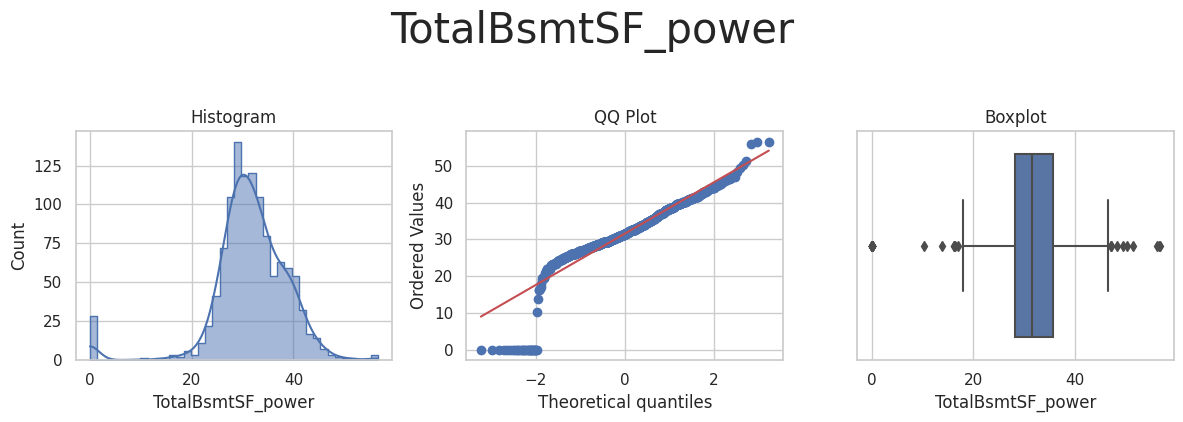

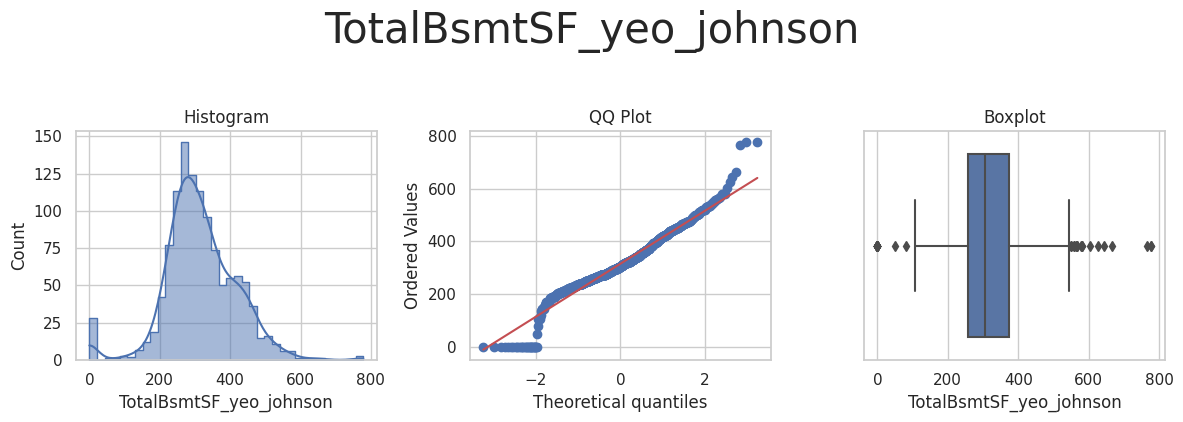



* Variable Analyzed: YearBuilt
* Applied transformation: ['YearBuilt_log_e', 'YearBuilt_log_10', 'YearBuilt_reciprocal', 'YearBuilt_power', 'YearBuilt_box_cox', 'YearBuilt_yeo_johnson'] 



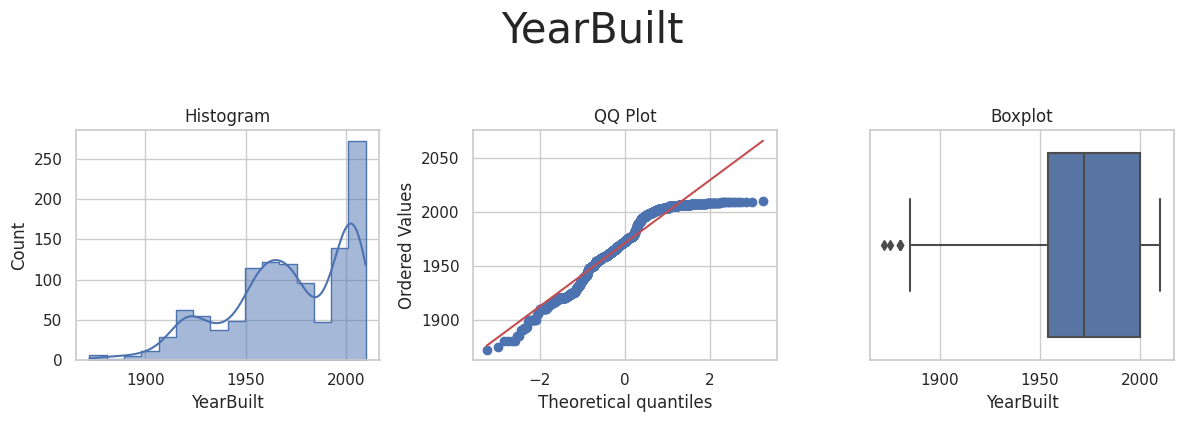

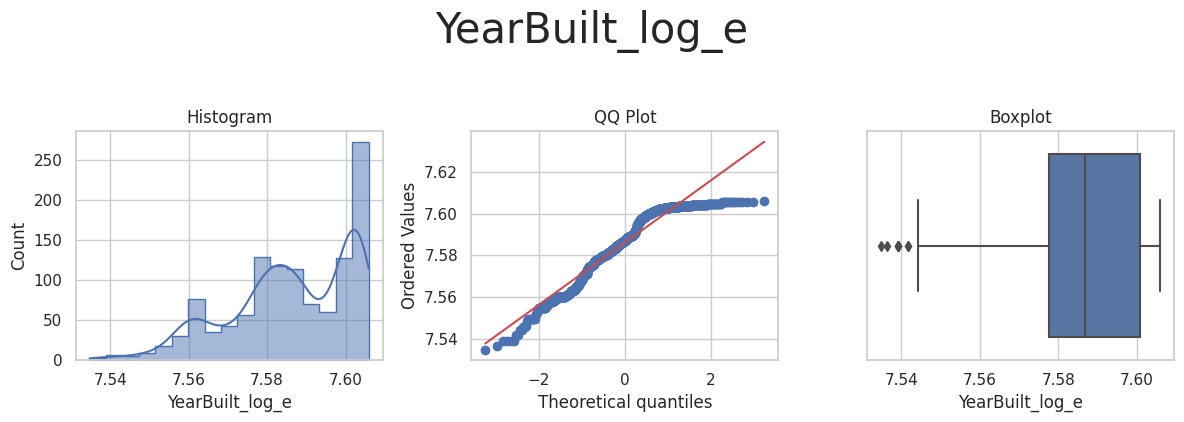

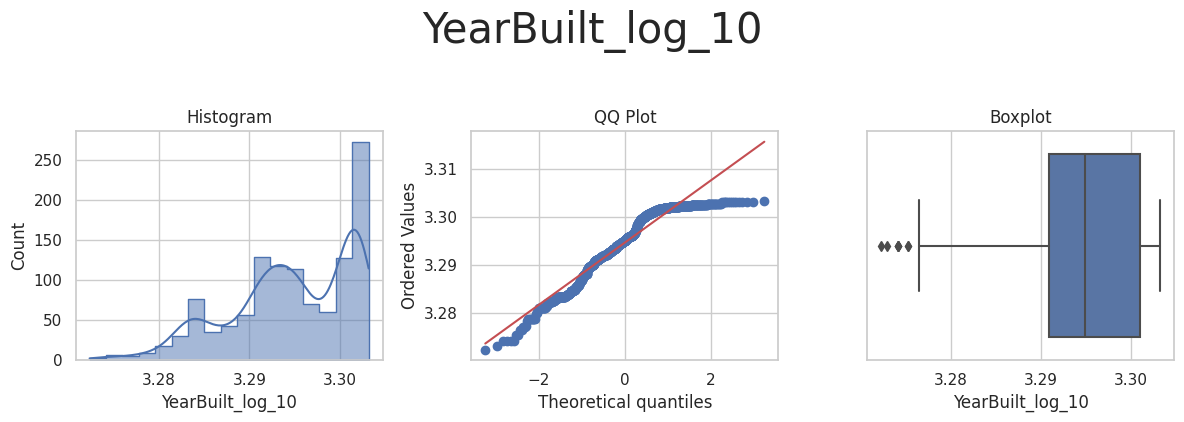

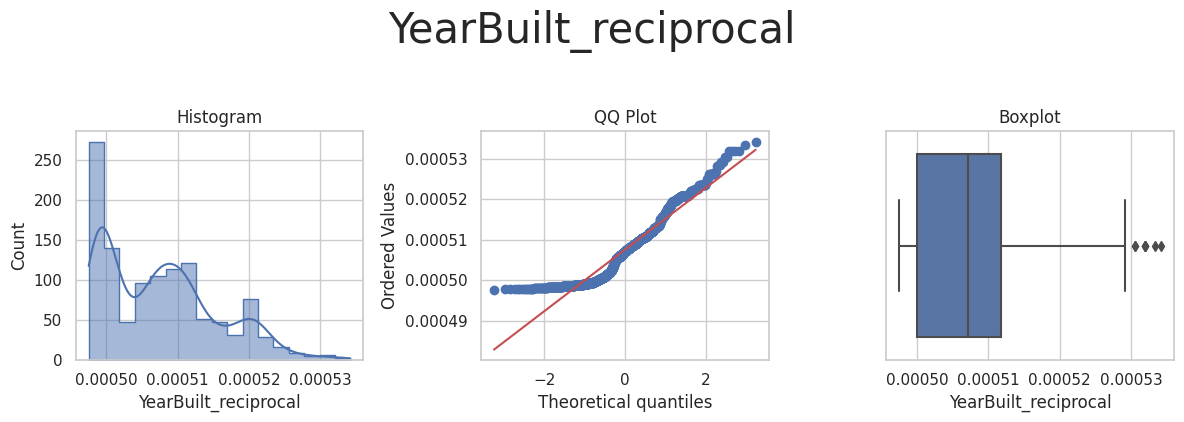

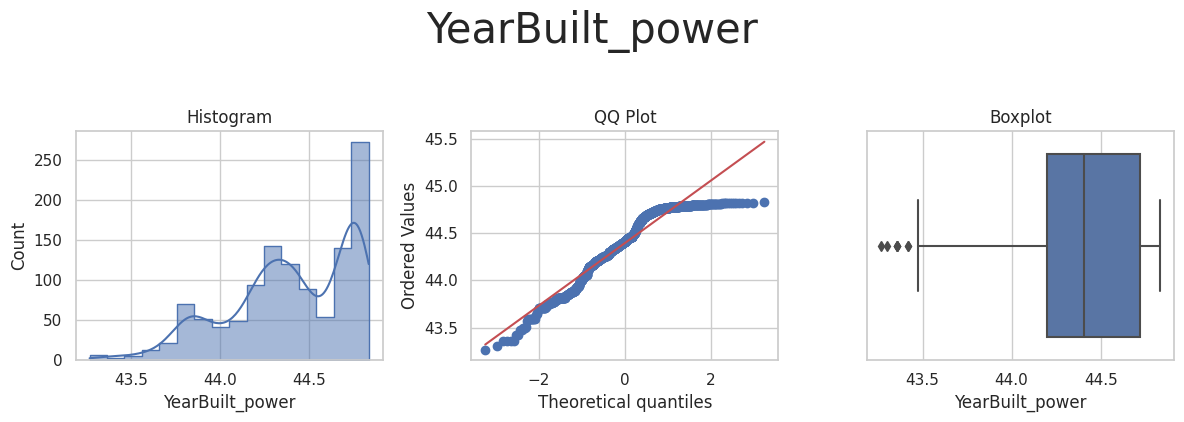

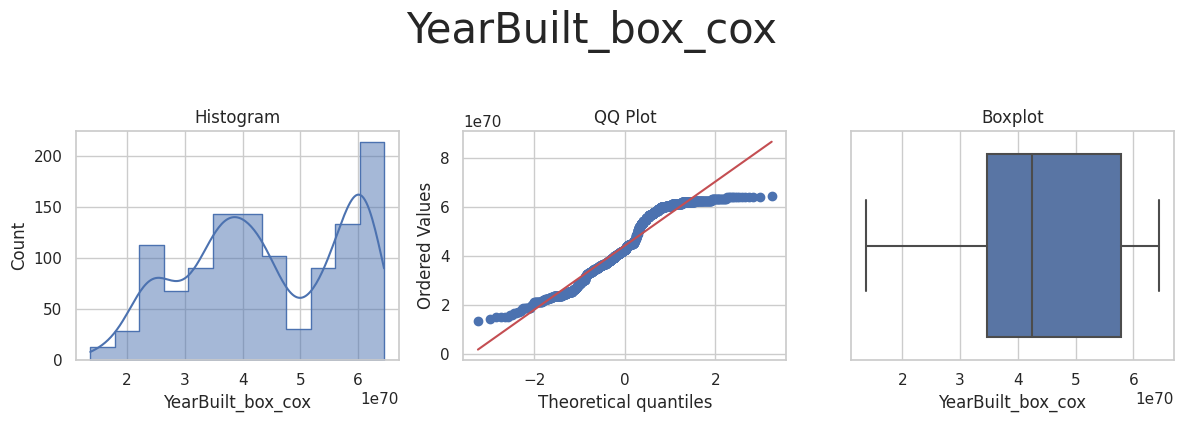

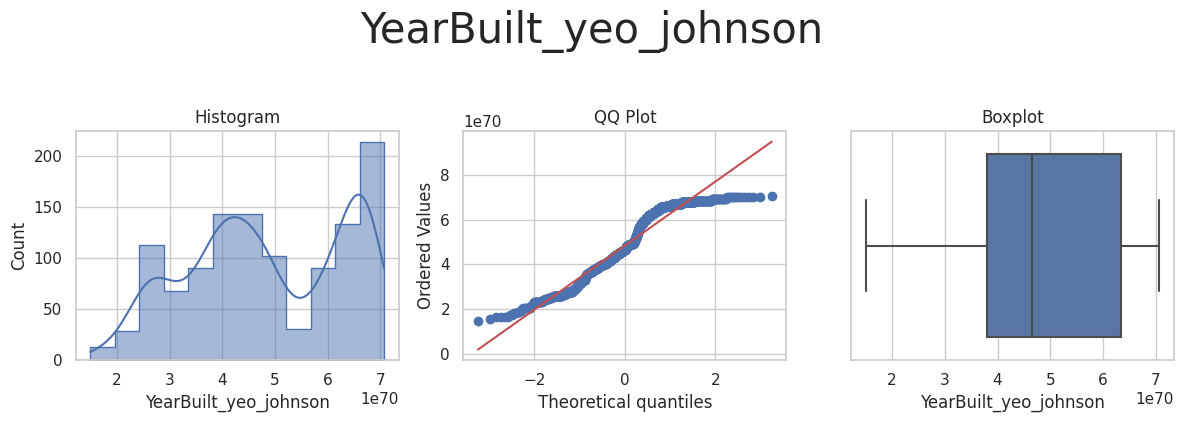



* Variable Analyzed: YearRemodAdd
* Applied transformation: ['YearRemodAdd_log_e', 'YearRemodAdd_log_10', 'YearRemodAdd_reciprocal', 'YearRemodAdd_power', 'YearRemodAdd_box_cox', 'YearRemodAdd_yeo_johnson'] 



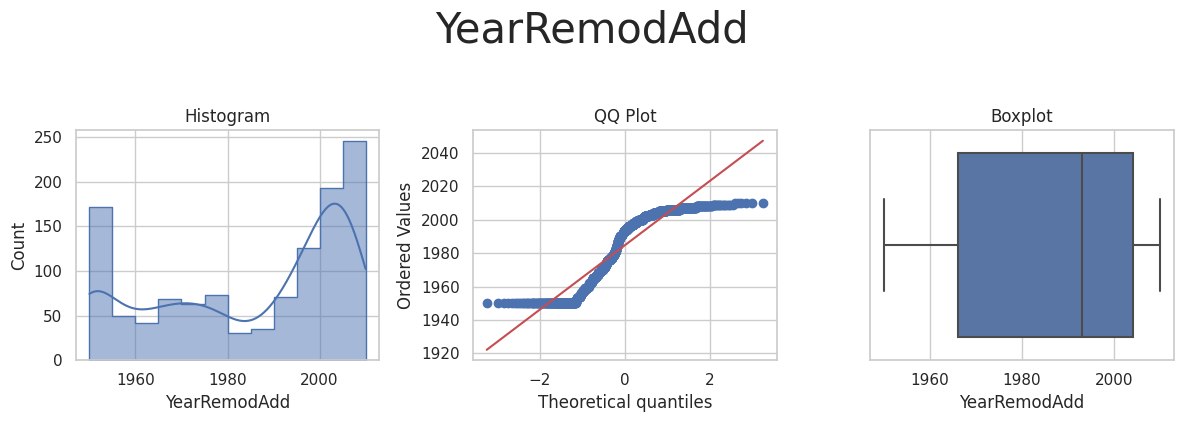

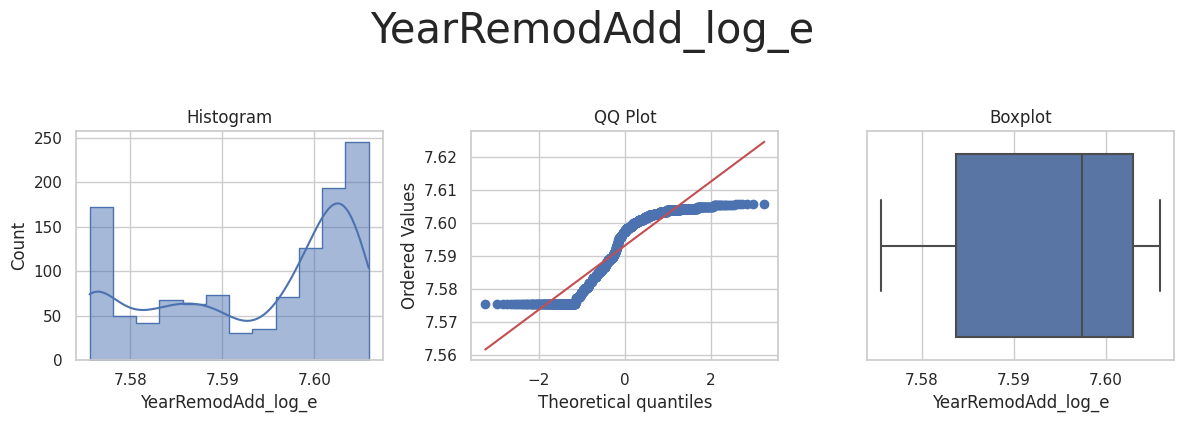

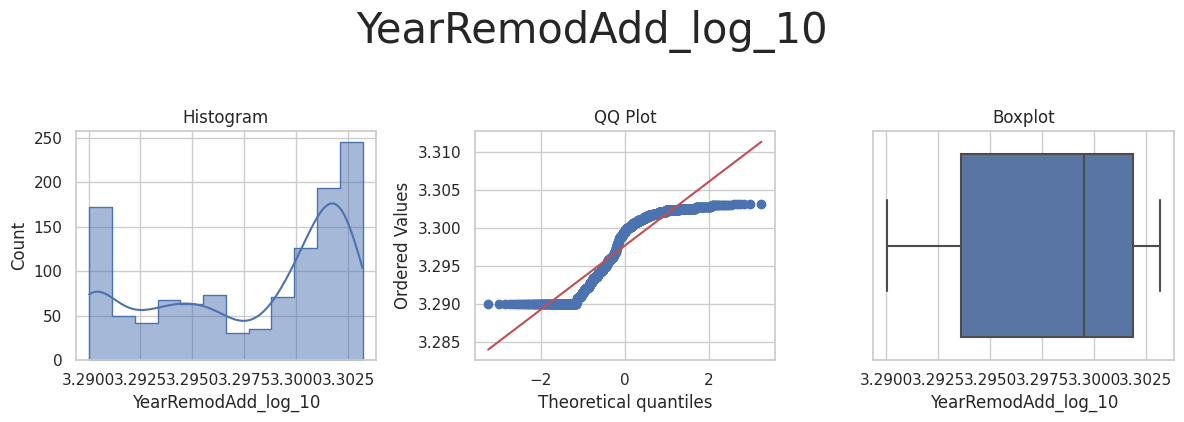

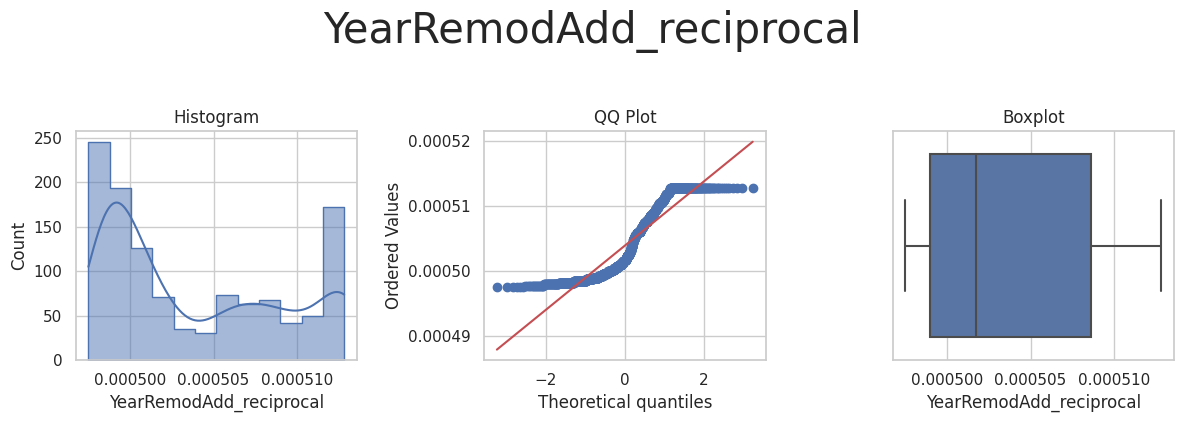

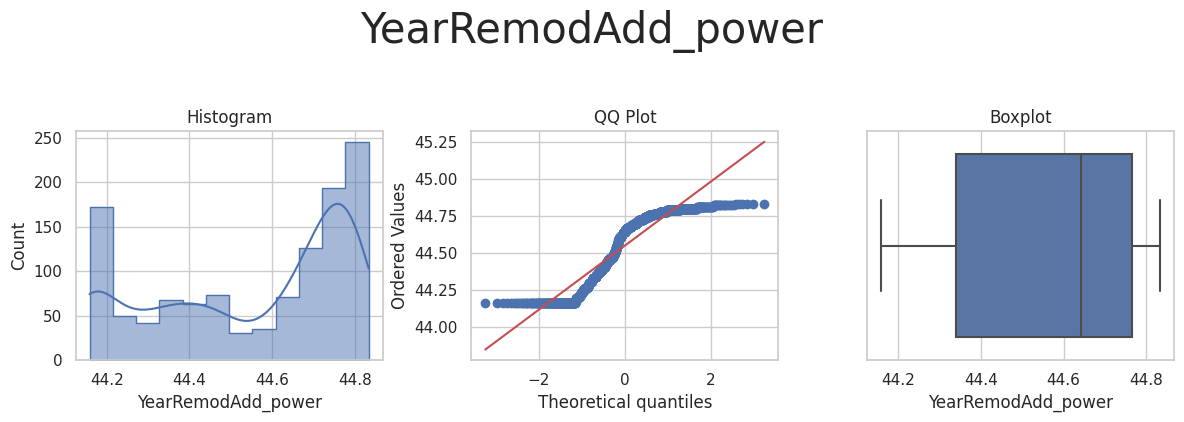

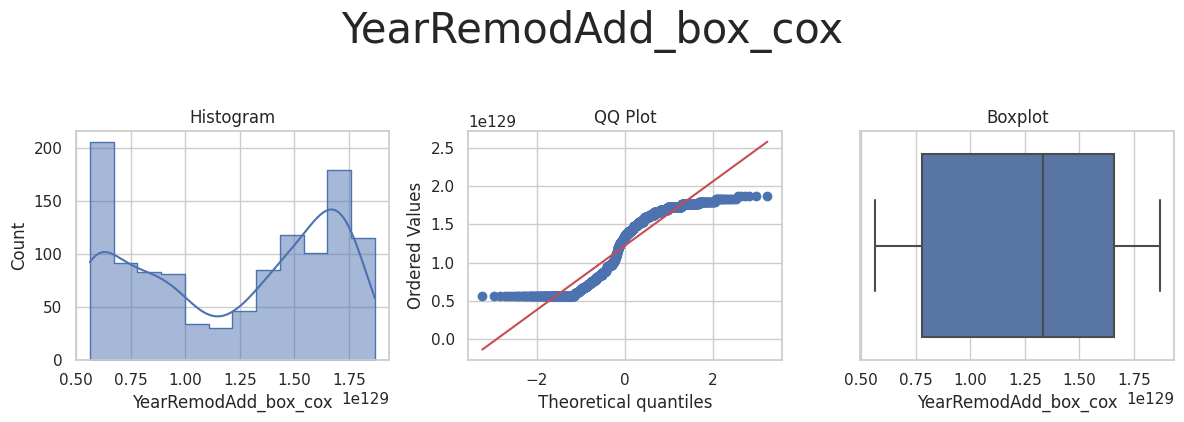

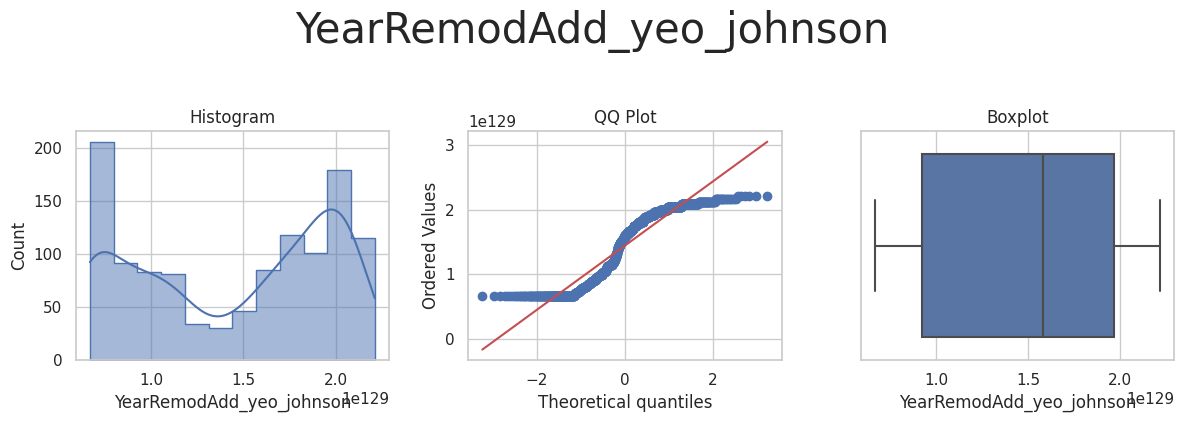



* Variable Analyzed: SalePrice
* Applied transformation: ['SalePrice_log_e', 'SalePrice_log_10', 'SalePrice_reciprocal', 'SalePrice_power', 'SalePrice_box_cox', 'SalePrice_yeo_johnson'] 



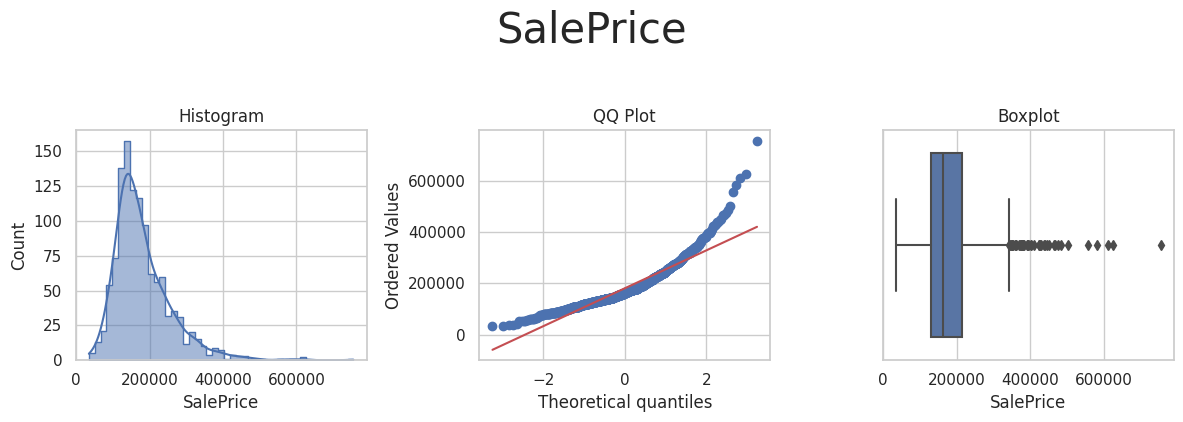

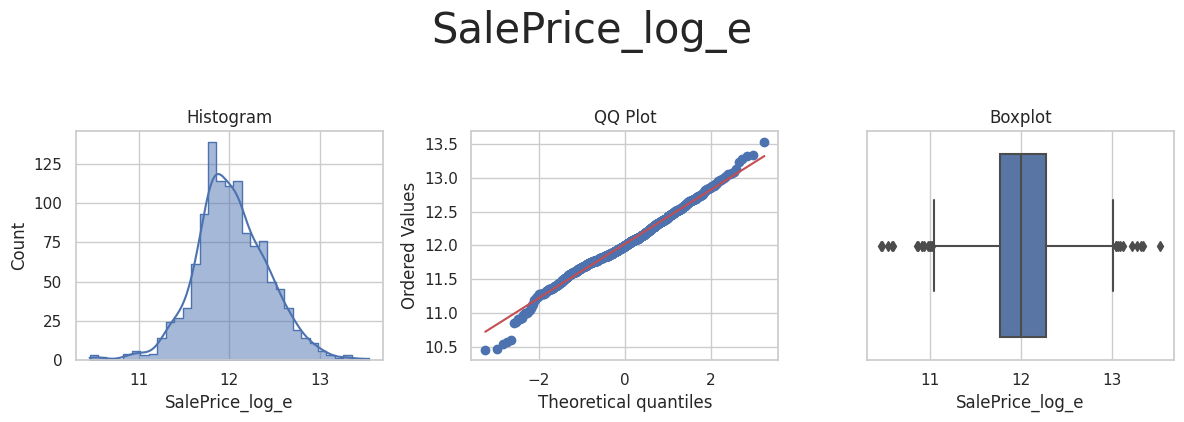

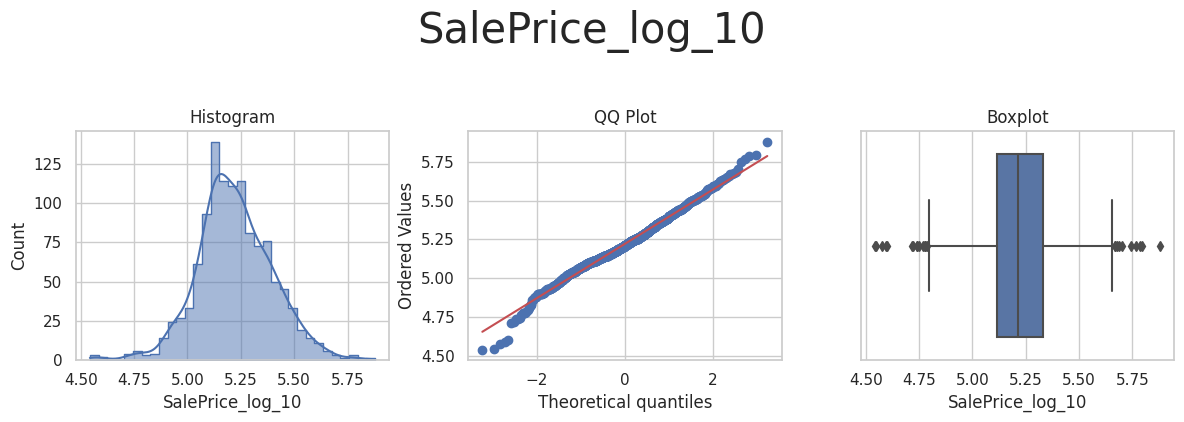

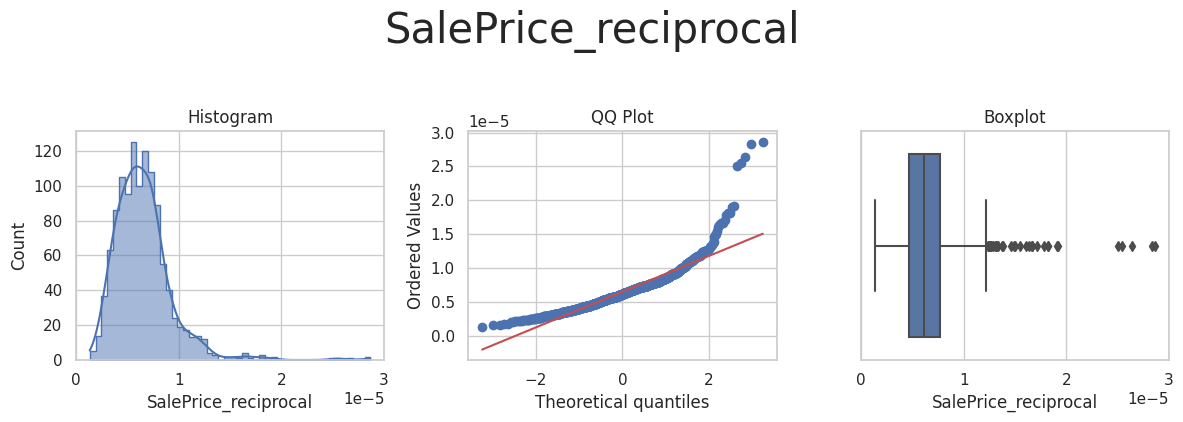

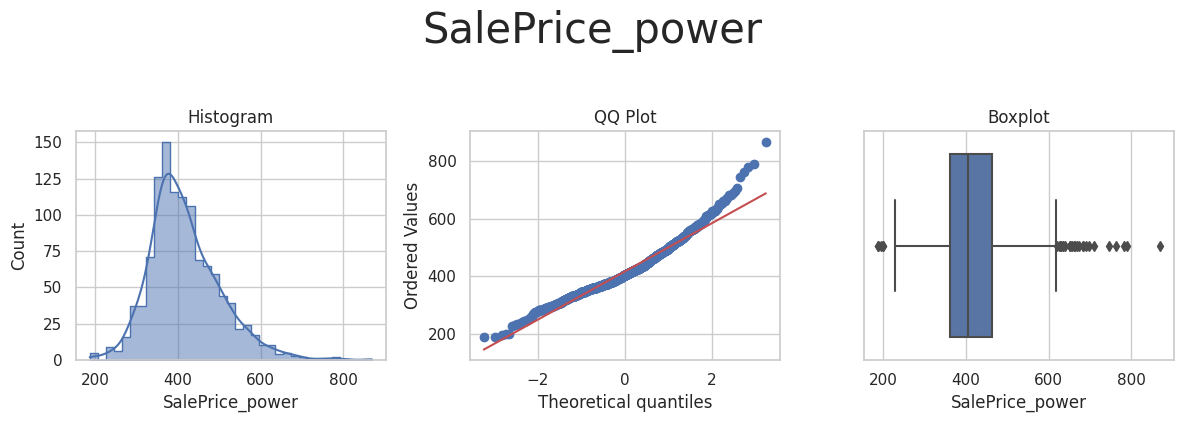

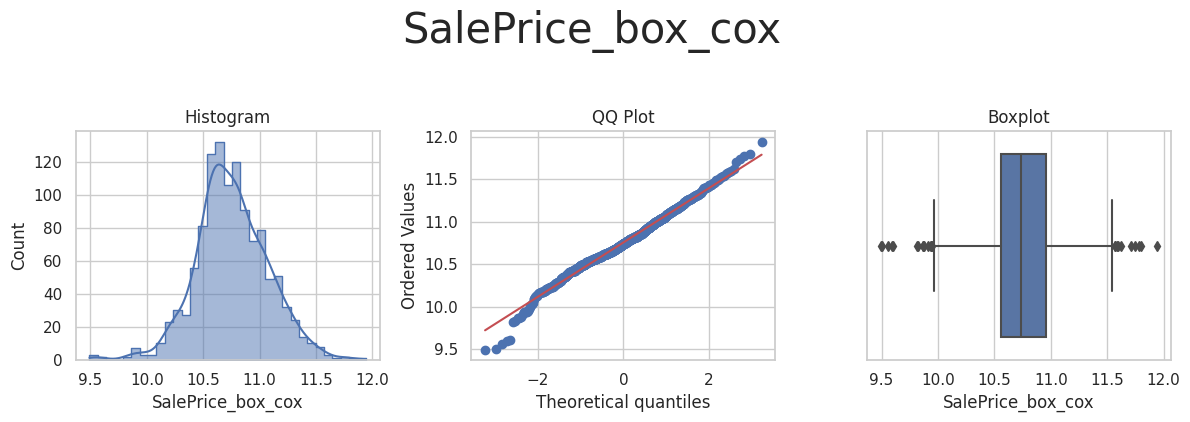

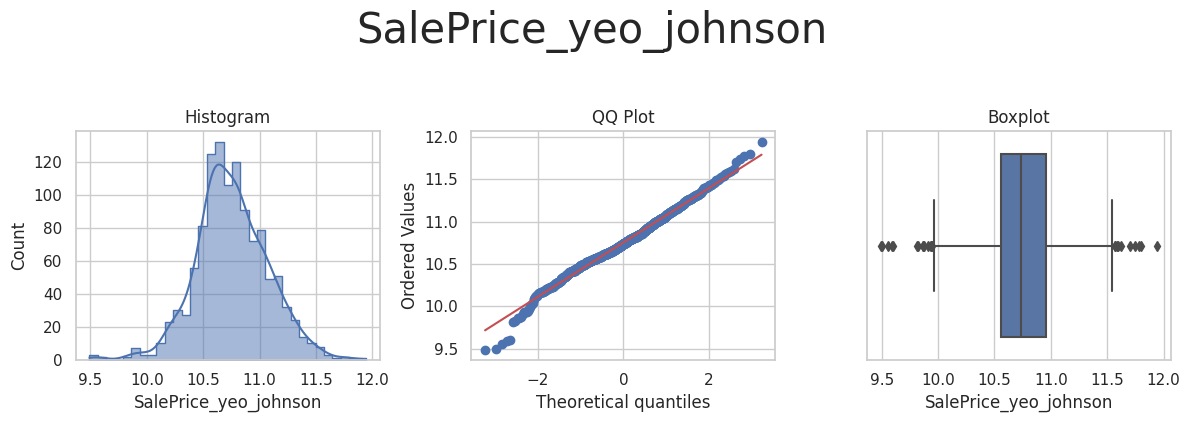

In [15]:
df_numerical_engineered = FeatureEngineeringAnalysis(df=df_numerical, analysis_type='numerical')

### Analysis of plots:

**1stFlrSF, GrLivArea, LotArea, SalePrice.**

- The following variables have been analyzed:
    - 1stFlrSF,
    - GrLivArea,
    - LotArea,
    - SalePrice.

- The applied transformation results:
    - Log e,
    - Log 10,
    - Reciprocal,
    - Power,
    - Box Cox,
    - Yeo Johnson.

- The exceptions of Reciprocal and Power, the applied transformation shows an improvement in terms of the distribution, shape and quality plot.
    - The transformed options have a characteristic of a normal distribution on each diagram.

*In Conclusion:*
*Log e, Log 10, Box Cox and Yeo Johnson may be considered for a numerical transformation for the variable: 1stFlrSF, GrlivArea, LotArea and SalePrice.*

___

**2ndFlrSF, BedroomAbvGr, BsmtFinSF1, BsmtUnfSF, GarageArea, GarageYrBlt, TotalBsmtSF.**

- The following variables have been analyzed:
    - 2ndFlrSF,
    - BedroomAbvGr,
    - BsmtFinSF1,
    - BsmtUnfSF,
    - GarageArea,
    - GarageYrBlt,
    - TotalBsmtSF.

- The applied transformation results:
    - Power,
    - Yeo Johnson.

- In the above analyzed variables we could see that there are just 2 transformations applied.
- As presented in the graphics, neither of the plots showed have an improvement in terms of distribution shape and quality plot.
    - The transformed options have a characteristic of a normal distribution on eac diagram.

*In conclusion, these variables will not be taken under consideration for the numerical transformation.*


____

**MasVnrArea**

- The following variable has been analyzed: MasVnrArea.
- The applied transformation results:
    - Power,
    - Yeo Johnson.

- In the above analyze we cold see that there ar just 2 transformations applied.
    Power: We could see an improvement in therms of distribution shape and QQ plot. Therefore, we could see the normal characteristics for distribution.
    - Yeo Johnson: unfortunately we cannot see any improvement. 

*In conclusion: 'Power' may be considered for numerical transformation of MasVnrArea.*

___

**LotFrontage, OverallCond, OverallQual.**

- The following variables have been analyzed:
    - LotFrontage,
    - OverallCond,
    - OverallQual.

- The applied transformation results:
    - Log e,
    - Log 10, 
    - Reciprocal,
    - Power,
    - Box Cox,
    - Yeo Johnson.

- In the above analyzed variables we could see 3 transformations applied.
    - Power,
    - Box Cox,
    - Yeo Johnson.
        - These transformations show similar results of distribution shape and QQ plot.

- However, Log e, Log 10 and Reciprocal dose not show any improvement.

*In conclusion, those variables will not be consider for the numerical transformation.*

___

**OpenPorchSF**

- The following variable has been analyzed:
    - OpenPorchSF.

- The applied transformation results:
    - Power,
    - Yeo Johnson.

- In the above analyzed variables we could see 2 transformations being applied.
    - Yeo Johnson: show improvement in terms of distribution shape and QQ plot.
    - Power: dose not show any improvement.

*In conclusion, Yeo johnson will be considered for numerical transformation.*

___

**YearBuilt, YearRemodAdd.**

- The following variables have been analyzed:
    - YearBuilt,
    - YearRemodAdd.

- The applied transformation results:
    - Log e,
    - Log 10,
    - Reciprocal,
    - Power,
    - Box Cox,
    - Yeo Johnson.

- In the above analyzed variables, we are unable to see any improvement.

*In conclusion, these variables will not be considered for numerical transformation.*





___

4. Apply the transformations to the Train and Test set:

In [16]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ("NumericLogTransform",vt.LogTransformer(variables=['1stFlrSF', 'LotArea', 'GrLivArea'])),
    ("NumericPowerTransform",vt.PowerTransformer(variables=['MasVnrArea'])),
    ("NumericYeoJohnsonTransform",vt.YeoJohnsonTransformer(variables=['OpenPorchSF']))
    ])
train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

print("* The numerical transformation has been completed!")

* The numerical transformation has been completed!


In [17]:
train_set.head()

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0  7.510978         0             0             0          48             0   
1  6.795706         0             2             1           0             1   
2  6.871091         0             2             1         713             2   
3  7.431892         0             3             1        1218             3   
4  7.340187         0             3             1           0             1   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  GrLivArea  KitchenQual  \
0       1774         774             0         2007   7.510978            0   
1        894         308             0         1962   6.795706            1   
2        163         432             0         1921   6.871091            1   
3        350         857             1         2002   7.431892            0   
4       1541         843             1         2001   7.340187            0   

    LotArea  LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0  9.366831           90   21.260292     4.880037            5            9   
1  8.794825           60    0.000000     0.000000            5            5   
2  9.500020           80    0.000000     0.000000            7            5   
3  9.492884           69   12.165525     4.237583            5            8   
4  9.525443          118   12.247449     4.572940            5            7   

   TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  
0         1822       2007          2007     314813  
1          894       1962          1962     109500  
2          876       1921          2006     163500  
3         1568       2002          2002     271000  
4         1541       2001          2002     205000

## SmartCorrelatedSelection Variables.

- In the following, we will use all the variables for SmartCorrelatedSelection method. 

1. Create a copy of the Train set data frame.

We will drop SalePrice as our task is to be able to predict the sale price.

In [18]:
df_temp = train_set.drop(['SalePrice'],axis=1)
df_temp.head(5)

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0  7.510978         0             0             0          48             0   
1  6.795706         0             2             1           0             1   
2  6.871091         0             2             1         713             2   
3  7.431892         0             3             1        1218             3   
4  7.340187         0             3             1           0             1   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  GrLivArea  KitchenQual  \
0       1774         774             0         2007   7.510978            0   
1        894         308             0         1962   6.795706            1   
2        163         432             0         1921   6.871091            1   
3        350         857             1         2002   7.431892            0   
4       1541         843             1         2001   7.340187            0   

    LotArea  LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0  9.366831           90   21.260292     4.880037            5            9   
1  8.794825           60    0.000000     0.000000            5            5   
2  9.500020           80    0.000000     0.000000            7            5   
3  9.492884           69   12.165525     4.237583            5            8   
4  9.525443          118   12.247449     4.572940            5            7   

   TotalBsmtSF  YearBuilt  YearRemodAdd  
0         1822       2007          2007  
1          894       1962          1962  
2          876       1921          2006  
3         1568       2002          2002  
4         1541       2001          2002

In [19]:
df_smart_corr_selection = df_temp.copy()
df_smart_corr_selection.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0  7.510978         0             0             0          48             0   
1  6.795706         0             2             1           0             1   
2  6.871091         0             2             1         713             2   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  GrLivArea  KitchenQual  \
0       1774         774             0         2007   7.510978            0   
1        894         308             0         1962   6.795706            1   
2        163         432             0         1921   6.871091            1   

    LotArea  LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0  9.366831           90   21.260292     4.880037            5            9   
1  8.794825           60    0.000000     0.000000            5            5   
2  9.500020           80    0.000000     0.000000            7            5   

   TotalBsmtSF  YearBuilt  YearRemodAdd  
0         1822       2007          2007  
1          894       1962          1962  
2          876       1921          2006

2. Create engineered variables using the spearman method and applying the above transformations:

In [20]:
from feature_engine.selection import SmartCorrelatedSelection
selection_method = "cardinality"
corr_method = 'spearman'
smart_corr_selection = SmartCorrelatedSelection(variables=None, method=corr_method, threshold=0.60, selection_method=selection_method)

smart_corr_selection.fit_transform(df_smart_corr_selection)
smart_corr_selection.correlated_feature_sets_

[{'1stFlrSF', 'TotalBsmtSF'},
 {'2ndFlrSF', 'GrLivArea'},
 {'GarageArea', 'GarageYrBlt'},
 {'OverallQual', 'YearBuilt'}]

3. We will be removing any surplus of the correlated features as those will be adding the same information to the model.

In [21]:
smart_corr_selection.features_to_drop_

['2ndFlrSF', 'GarageYrBlt', 'OverallQual', 'TotalBsmtSF']

___

## Conclusion

- Feature Engineering Transformers: 
    - The ordinal categorical encoding is: BsmtExposure, BsmtFinType1, GarageFinish and KitchenQual.
    - The numerical transformation is: Log e, Log 10, Box Cox and YeoJohnson.
        - Those transformations are considered for 1stFlrSF, LotArea and SalePrice.


- As previously mentioned the SalePrice has been dropped as our task will be to predict it. 

- Power will be considerate for GarageArea and MasVnrArea to be transformed in numerical type.
- For GrLivArea we will consider Log e, Log 10, Power, Box Cox and Yeo Johnson as a numerical type.
- For OpenPorchSF we will consider Yeo Johnson as a numerical type.


The following transformers will be used:
- ("NumericLogTransform",vt.LogTransformer(variables=['1stFlrSF', 'GrLivArea', 'LotArea'])),
- ("NumericPowerTransform",vt.PowerTransformer(variables=['GarageArea', 'MasVnrArea'])),
- ("NumericYeoJohnsonTransform",vt.YeoJohnsonTransformer(variables=['OpenPorchSF'])).

*As seen in the sale_price_study the strongest variables correlated are:*
- 1stFlrSF,
- GarageArea,
- GrLivArea,
- OverallQual,
- TotalBsmtSF,
- YearBuilt.

**Smart Correlation**

- We have dropped the following features:
    - 2ndFlrSF,
    - GarageYrBlt,
    - OveralQual,
    - TotalBsmtSF.

- After combinations of correlation methods and selection methods we came to the following conclusion.
- Spearman: 
    - Cardinality: 1stFlrSF, GrLivArea, GarageArea and YearBuilt.
    - We Drop: 2ndFlrSF, GarageYrBlt, OverallQual and TotalBsmtSF.
    - Variance: TotalBsmtSF, 2ndFlrSF, GarageYrBlt and YearBuilt.
    - We Drop: 1stFlrSF, GarageArea, GrLivArea and OverallQual.

- Pearson:
    - Cardinality: 1stFlrSF, GrLivArea and GarageArea.
    - We drop: 2ndFlrSF, GarageYrBlt and TotalBsmtSF.
    - Variance: TotalBsmtSF, 2ndFlrSF and GarageYrBlt.
    - We drop: 1stFlrSF, GarageArea and GrLivArea.

___